# 0. Librerias

In [1]:
# Genérica
# -----------------------------------------------------------------------------
from time import time
import session_info


# Tratamientos datos
# -----------------------------------------------------------------------------
import json
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np


# category encoders
# -----------------------------------------------------------------------------
from category_encoders import OrdinalEncoder


# scikit-learn
# -----------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# LightGBM
# -----------------------------------------------------------------------------
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation


# Gráficos
# -----------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt


session_info.show(html=False)

-----
category_encoders   2.6.1
lightgbm            3.3.5
matplotlib          3.7.2
numpy               1.23.5
pandas              1.5.3
seaborn             0.12.2
session_info        1.0.0
sklearn             1.3.0
-----
IPython             8.14.0
jupyter_client      8.3.0
jupyter_core        5.3.1
notebook            6.5.4
-----
Python 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
Linux-5.15.0-107-generic-x86_64-with-glibc2.31
-----
Session information updated at 2024-05-23 15:45


In [2]:
# Funciones
# -----------------------------------------------------------------------------
def optimize_df_dtypes(df):

    variables_categoricas = [
        'Epoca_Covid',
        'Anio',
        'Trimestre',
        'Mes',
        'Negocio',
        'Cliente',
        'Tipo_Cliente',
        'Distribuidor_MSM',
        'Codigo_Postal',
        'Area_Dist',
        'Zona',
        'ID_CCAA',
        'Comunidad_Autonoma',
        'ID_Provincia',
        'Provincia',
        'Gama',
        'Descripcion_Gama',
        'Formato_1',
        'Formato_2',
        'Dureza_Agua'
    ]
    
    variables_enteras = [
        'Num_PdV_CI',
        'Num_PdV_RU', 
        'Num_PdV_TU', 
        'Impactos_TV', 
        'Sell_In_PP', 
        'Marketing_Nacional', 
        'Trade_Marketing', 
        'Marketing_PLV',
        'Dispersion_PdV',
        'Volumen_Solicitado',
        'Tarifa_Eur_Hl', 
        'Margen_Distribuidor', 
        'Egatur', 
        'Familitur',
        'Num_Manantiales',
        'Sell_In_1', 
        'Sell_In'
    ]
    
    variables_decimales = [
        'IPC', 
        'IPRI', 
        'Temperatura_Media', 
        'Precipitacion',
        'Nivel_Embalses'
        # 'Stock'
    ]

    for i in df.columns:
        if i in variables_categoricas:
            df[i] = df[i].astype('category')
        elif i in variables_enteras:
            df[i] = df[i].astype('int')
        elif i in variables_decimales:
            df[i] = df[i].astype('float')
        else:
            pass
 
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns

    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df 

# 1. Cargar datos

In [3]:
# Ruta
path = './data/si-train-5.csv'

# Cargar datos, especificando los dtypes para cada columna
df = pd.read_csv(path, sep=';')

# Optimizar tipo dato
df = optimize_df_dtypes(df)

# Dataset completo (copia seguridad)
df_complete = df.copy()

# Dataset de validación final
filter_val = ((df.Fecha >= 202401) & (df.Fecha <= 202403)) 
df_val = df[filter_val].reset_index(drop=True)

# Dataset de entrenamiento
filter_train = (df.Fecha <= 202312)
df = df[filter_train].reset_index(drop=True)

df.head()

/tmp/ipykernel_26187/2545773912.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=';')


,Fecha,Epoca_Covid,Anio,Mes,Negocio,Cliente,Tipo_Cliente,Codigo_Postal,Area_Dist,ID_Provincia,Provincia,ID_CCAA,Comunidad_Autonoma,Gama,Descripcion_Gama,Formato_1,Formato_2,Num_PdV_CI,Num_PdV_RU,Num_PdV_TU,Impactos_TV,Sell_In_PP,Marketing_Nacional,Trade_Marketing,Marketing_PLV,Dispersion_PdV,Volumen_Solicitado,Tarifa_Eur_Hl,Margen_Distribuidor,Egatur,Familitur,IPC,IPRI,Temperatura_Media,Precipitacion,Num_Manantiales,Nivel_Embalses,Dureza_Agua,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,No retornable,Lata,0,60,459,0,0,130,39,64,32,0,325,27,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,18,21,2024-05-14T13:57:42.649Z,202404
1,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,No retornable,Tercio SR,0,60,459,0,0,-63,-3187,33,32,0,505,56,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,23,12,2024-05-14T13:57:42.649Z,202404
2,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,Retornable,Quinto,0,60,459,0,0,387,120,158,32,0,378,65,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,84,50,2024-05-14T13:57:42.649Z,202404
3,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,Retornable,Tercio,0,60,459,0,0,3450,1073,1247,32,0,380,51,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,543,433,2024-05-14T13:57:42.649Z,202404
4,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,SM,San Miguel,Barril,Barril,0,1,4,0,0,0,0,0,32,0,359,32,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,0,0,2024-05-14T13:57:42.649Z,202404


## 1.1. EDA

In [4]:
# DTypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752255 entries, 0 to 2752254
Data columns (total 42 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Fecha                 int32   
 1   Epoca_Covid           category
 2   Anio                  category
 3   Mes                   category
 4   Negocio               category
 5   Cliente               category
 6   Tipo_Cliente          category
 7   Codigo_Postal         category
 8   Area_Dist             category
 9   ID_Provincia          category
 10  Provincia             category
 11  ID_CCAA               category
 12  Comunidad_Autonoma    category
 13  Gama                  category
 14  Descripcion_Gama      category
 15  Formato_1             category
 16  Formato_2             category
 17  Num_PdV_CI            int16   
 18  Num_PdV_RU            int16   
 19  Num_PdV_TU            int16   
 20  Impactos_TV           int32   
 21  Sell_In_PP            int16   
 22  Marketing_Nacional

In [5]:
# Separar datasets
dates_complete = df_complete['Fecha'].nunique()
dates_train = df['Fecha'].nunique()
dates_val = df_val['Fecha'].nunique()

print(f"Fechas totales: {dates_complete}")
print(f"Fechas entrenamiento: {dates_train}")
print(f"Fechas validación: {dates_val}")

Fechas totales: 72
Fechas entrenamiento: 69
Fechas validación: 3


In [6]:
sorted(df['Fecha'].unique())

[201610,
 201611,
 201612,
 201701,
 201702,
 201703,
 201704,
 201705,
 201706,
 201707,
 201708,
 201709,
 201710,
 201711,
 201712,
 201801,
 201802,
 201803,
 201804,
 201805,
 201806,
 201807,
 201808,
 201809,
 201810,
 201811,
 201812,
 201901,
 201902,
 201903,
 201904,
 201905,
 201906,
 201907,
 201908,
 201909,
 201910,
 201911,
 201912,
 202001,
 202002,
 202109,
 202110,
 202111,
 202112,
 202201,
 202202,
 202203,
 202204,
 202205,
 202206,
 202207,
 202208,
 202209,
 202210,
 202211,
 202212,
 202301,
 202302,
 202303,
 202304,
 202305,
 202306,
 202307,
 202308,
 202309,
 202310,
 202311,
 202312]

In [7]:
# Conteo por Negocio
df['Negocio'].value_counts()

UNE    2110182
UNA     642073
Name: Negocio, dtype: int64

In [8]:
# Conteo por Formato_1
df[['Negocio', 'Formato_1']].value_counts()

Negocio  Formato_1    
UNE      No retornable    1139987
         Retornable        511860
UNA      No retornable     501954
UNE      Barril            458335
UNA      Retornable        140051
         Barril                68
dtype: int64

In [9]:
# Conteo por Negocio-Formato_2
df[['Negocio', 'Formato_2']].value_counts()

Negocio  Formato_2       
UNE      Tercio SR           547612
         Barril              436494
         Tercio              362638
         Lata                357156
UNA      PET 0,50 L          150206
UNE      Quinto              149222
         Cuarto SR           104526
UNA      PET 1,50 L           93371
         PET 0,33 L           89908
         MEDIO LITRO          76036
UNE      Gran Formato         64907
UNA      LITRO                50839
         TERCIO SR            48199
UNE      Medio Litro SR       46721
UNA      PET 5,00 L           35983
         PET 1,00 L           22989
UNE      Duotank              21841
UNA      PET 0,75 L           19565
UNE      Quinto SR            15976
UNA      GRAN FORMATO         13574
         Lata                 11112
         PET GRAN FORMATO      9586
         CR 0,33 L             6332
         CUARTO SR             6183
         CR 0,75 L             5974
UNE      Bag in Box            3089
UNA      11 Litros              784
  

In [10]:
# Eliminar columnas genéricas para todos los experimentos
df = df.drop(columns=[
    'Fecha',
    'Anio',
    'Cliente',
    'Codigo_Postal',
    'Provincia',
    'ID_CCAA',
    'Comunidad_Autonoma',
    'Descripcion_Gama',
    'STRATIO_CREATED_DATE',
    'exec_month'
])

In [11]:
# Contar el número de NaN por columna
num_nan_por_columna = df.isna().sum()
print(num_nan_por_columna)

Epoca_Covid            0
Mes                    0
Negocio                0
Tipo_Cliente           0
Area_Dist              0
ID_Provincia           0
Gama                   0
Formato_1              0
Formato_2              0
Num_PdV_CI             0
Num_PdV_RU             0
Num_PdV_TU             0
Impactos_TV            0
Sell_In_PP             0
Marketing_Nacional     0
Trade_Marketing        0
Marketing_PLV          0
Dispersion_PdV         0
Volumen_Solicitado     0
Tarifa_Eur_Hl          0
Margen_Distribuidor    0
Egatur                 0
Familitur              0
IPC                    0
IPRI                   0
Temperatura_Media      0
Precipitacion          0
Num_Manantiales        0
Nivel_Embalses         0
Dureza_Agua            0
Sell_In_1              0
Sell_In                0
dtype: int64


In [12]:
# Variable dependiente
target = 'Sell_In'

# Variables independientes
features = list(df.columns)
features.remove(target)

# Variables categóricas
categorical_features = [col for col in df.columns if df[col].dtype == 'category']

# Mostrar
print(f'Variables dependiente: 1')
print(f'{target}')
print(30*'-')
print(f'Variables independientes: {len(features)}')
print(f'{features}')
print(30*'-')
print(f'Variables categóricas: {len(categorical_features)}')
print(f'{categorical_features}')

Variables dependiente: 1
Sell_In
------------------------------
Variables independientes: 31
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']
------------------------------
Variables categóricas: 10
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Dureza_Agua']


## 1.2. Heatmaps de Volumen

In [13]:
df_complete.head()

,Fecha,Epoca_Covid,Anio,Mes,Negocio,Cliente,Tipo_Cliente,Codigo_Postal,Area_Dist,ID_Provincia,Provincia,ID_CCAA,Comunidad_Autonoma,Gama,Descripcion_Gama,Formato_1,Formato_2,Num_PdV_CI,Num_PdV_RU,Num_PdV_TU,Impactos_TV,Sell_In_PP,Marketing_Nacional,Trade_Marketing,Marketing_PLV,Dispersion_PdV,Volumen_Solicitado,Tarifa_Eur_Hl,Margen_Distribuidor,Egatur,Familitur,IPC,IPRI,Temperatura_Media,Precipitacion,Num_Manantiales,Nivel_Embalses,Dureza_Agua,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,No retornable,Lata,0,60,459,0,0,130,39,64,32,0,325,27,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,18,21,2024-05-14T13:57:42.649Z,202404
1,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,No retornable,Tercio SR,0,60,459,0,0,-63,-3187,33,32,0,505,56,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,23,12,2024-05-14T13:57:42.649Z,202404
2,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,Retornable,Quinto,0,60,459,0,0,387,120,158,32,0,378,65,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,84,50,2024-05-14T13:57:42.649Z,202404
3,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,Retornable,Tercio,0,60,459,0,0,3450,1073,1247,32,0,380,51,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,543,433,2024-05-14T13:57:42.649Z,202404
4,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,SM,San Miguel,Barril,Barril,0,1,4,0,0,0,0,0,32,0,359,32,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,0,0,2024-05-14T13:57:42.649Z,202404


In [14]:
# Columnas del análisis
mask = df_complete.Anio==2023
df_heatmap = df_complete[mask][['Anio', 'Negocio', 'Area_Dist', 'Formato_1', 'Formato_2', 'Sell_In']].copy()

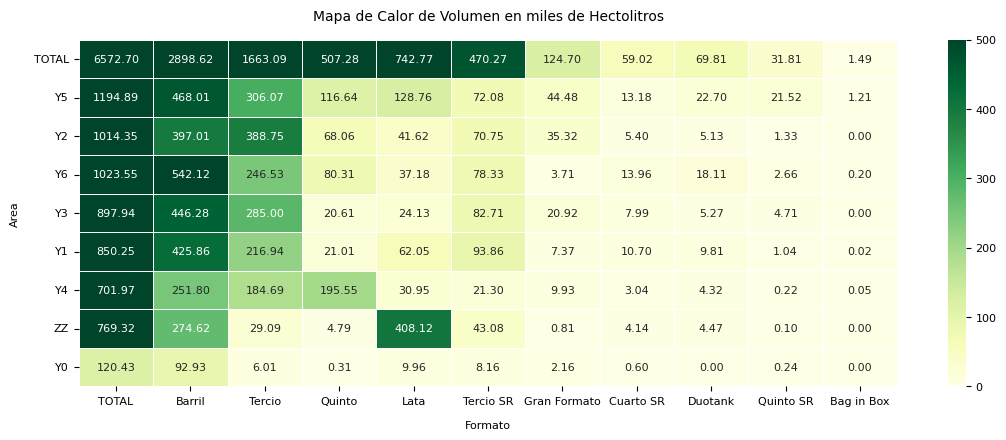

In [15]:
# Filtrar para UNE
mask = (df_heatmap.Negocio=='UNE')
df_heatmap_une = df_heatmap[mask]

df_heatmap_une = df_heatmap_une.pivot_table(
        index='Area_Dist',
        columns=['Formato_2'],
        values='Sell_In',
        aggfunc='sum'
        )

df_heatmap_une = df_heatmap_une / 1000

# Añadir TOTALES
df_heatmap_une['TOTAL'] = df_heatmap_une.sum(axis=1)
df_heatmap_une.loc['TOTAL'] = df_heatmap_une.sum(axis=0)

# Orden columnas e index
orden_col = [
    'TOTAL',
    'Barril',
    'Tercio',
    'Quinto',
    'Lata',
    'Tercio SR',
    'Gran Formato',
    'Cuarto SR',
    'Duotank',
    'Quinto SR',
    'Bag in Box'
]

orden_index = {key: i for i, key in enumerate(['TOTAL', 'Y5', 'Y2', 'Y6', 'Y3', 'Y1', 'Y4', 'ZZ', 'Y0'])}

df_heatmap_une = df_heatmap_une.sort_index(key=lambda x: x.map(orden_index))


# Cambiar el tamaño del mapa de calor
# --------------------------------------------------------------------------
num_filas, num_columnas = df_heatmap_une[orden_col].shape
tamaño_ancho = num_columnas * 1.2
tamaño_alto = num_filas * 0.5

plt.figure(figsize=(tamaño_ancho, tamaño_alto))

# Mapa de calor
heatmap = sns.heatmap(
    df_heatmap_une[orden_col],
    annot=True,
    fmt='.2f',
    cmap='YlGn',
    vmin=0,
    vmax=500,
    linewidth=.5,
    annot_kws={"size": 8},
    )

# Personalizar mapa de calor
plt.title('Mapa de Calor de Volumen en miles de Hectolitros', fontsize=10, pad=14)

plt.xlabel('Formato', fontsize=8, labelpad=10)
plt.ylabel('Area', fontsize=8, labelpad=10)

plt.xticks(rotation=0, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

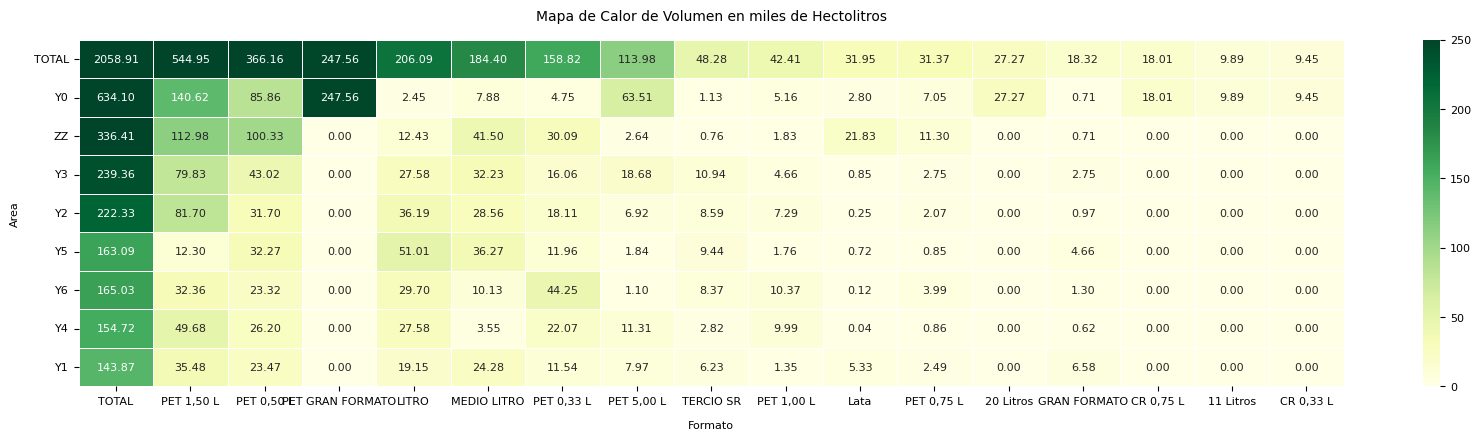

In [16]:
# Filtrar para UNE
mask = (df_heatmap.Negocio=='UNA')
df_heatmap_una = df_heatmap[mask]

df_heatmap_una = df_heatmap_una.pivot_table(
        index='Area_Dist',
        columns=['Formato_2'],
        values='Sell_In',
        aggfunc='sum'
        )

df_heatmap_una = df_heatmap_una / 1000

# Añadir TOTALES
df_heatmap_una['TOTAL'] = df_heatmap_una.sum(axis=1)
df_heatmap_una.loc['TOTAL'] = df_heatmap_una.sum(axis=0)

# Orden columnas e index
orden_col = [
    'TOTAL',
    'PET 1,50 L',
    'PET 0,50 L',
    'PET GRAN FORMATO',
    'LITRO',
    'MEDIO LITRO',
    'PET 0,33 L',
    'PET 5,00 L',
    'TERCIO SR',
    'PET 1,00 L',
    'Lata',
    'PET 0,75 L',
    '20 Litros',
    'GRAN FORMATO',
    'CR 0,75 L',
    '11 Litros',
    'CR 0,33 L'
]
        
orden_index = {key: i for i, key in enumerate(['TOTAL', 'Y0', 'ZZ', 'Y3', 'Y2', 'Y5', 'Y6', 'Y4', 'Y1'])}


df_heatmap_una = df_heatmap_una.sort_index(key=lambda x: x.map(orden_index))


# Cambiar el tamaño del mapa de calor
# --------------------------------------------------------------------------
num_filas, num_columnas = df_heatmap_una[orden_col].shape
tamaño_ancho = num_columnas * 1.2
tamaño_alto = num_filas * 0.5

plt.figure(figsize=(tamaño_ancho, tamaño_alto))

# Mapa de calor
heatmap = sns.heatmap(
    df_heatmap_una[orden_col],
    annot=True,
    fmt='.2f',
    cmap='YlGn',
    vmin=0,
    vmax=250,
    linewidth=.5,
    annot_kws={"size": 8},
    )

# Personalizar mapa de calor
plt.title('Mapa de Calor de Volumen en miles de Hectolitros', fontsize=10, pad=14)

plt.xlabel('Formato', fontsize=8, labelpad=10)
plt.ylabel('Area', fontsize=8, labelpad=10)

plt.xticks(rotation=0, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

## 1.3. Test funcionales

In [17]:
def test_ok():
    print("\033[92m" + 13*"-" + "\033[0m")
    print("\033[92m" + "-- Test OK --" + "\033[0m")
    print("\033[92m" + 13*"-" + "\033[0m")
    
def test_ko():
    print("\033[91m" + 13*"-" + "\033[0m")
    print("\033[91m" + "-- Test KO --" + "\033[0m")
    print("\033[91m" + 13*"-" + "\033[0m")

In [18]:
# Todos los DHC tienen el área ZZ
prueba = (df_complete.Tipo_Cliente == 'DHC') & (df_complete.Area_Dist != 'ZZ')

if df[prueba].shape[0] == 0:
    test_ok()
else:
    test_ko()
    print(df_complete[['Cliente', 'Tipo_Cliente', 'Area_Dist']][prueba].drop_duplicates().head(5))

-------------
-- Test OK --
-------------


/tmp/ipykernel_26187/1917702575.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if df[prueba].shape[0] == 0:


# 2. MLflow

In [19]:
# Importar MLflow
import mlflow
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema, ColSpec

In [20]:
# Ver ruta actual desde donde se va a levantar el MLflow server
!pwd

/home/gmachin/git/personal/project-sell-in-forecast


In [21]:
# Iniciar un servidor de MLflow con alguno de los dos comandos siguientes en una terminal
# $ mlflow server --host 127.0.0.1 --port 5000
# $ mlflow ui

In [22]:
# Apuntar el notebook al servidor MLflow levantado en la celda anterior
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [61]:
# Crear un experimento
# --------------------------------------------------

# Nombre
experiment_name = "MSM_Sell_In_Modelos_Formato_Fase5"

# Descripción
experiment_description = (
    "Proyecto de comparación de modelos de Sell In en función del Negocio y el Formato2."
)

# Etiquetas del experimento
experiment_tags = {
    "project_name": "Modelos-Sell-In",
    "problem_type": "Regresión",
    "client": "MSM",
    "mlflow.note.content": experiment_description,
}

# Crear el experimento
produce_sell_in_experiment = mlflow.create_experiment(
    name=experiment_name,
    tags=experiment_tags
)

# Activar el experimento
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/385982964012011333', creation_time=1715690019527, experiment_id='385982964012011333', last_update_time=1715690019527, lifecycle_stage='active', name='MSM_Sell_In_Modelos_Formato_Fase5', tags={'client': 'MSM',
 'mlflow.note.content': 'Proyecto de comparación de modelos de Sell In en '
                        'función del Negocio y el Formato2.',
 'problem_type': 'Regresión',
 'project_name': 'Modelos-Sell-In'}>

# 3. Modelos

## 3.1. Funciones

### 3.1.1. Entrenar modelo

In [23]:
# Función que entrena el modelo con un dataset de entrada, y unos parámetros
# definidos por el usuario, logga el modelo entrenado y las métricas en MLflow,
# y devuelve la URI del modelo en el MLflow server.
# -----------------------------------------------------------------------------
def execute_model(df, seed, model_params):
    
    # LightGBM
    import lightgbm as lgb

    # Medir tiempo
    tiempo_inicial = time()


    # Dataset de test y entrenamiento
    # --------------------------------------------------------------------------
    # Variable dependiente
    target = 'Sell_In'

    # Variables independientes
    features = list(df.columns)
    features.remove(target)

    # Variables categóricas
    categorical_features = [col for col in df.columns if df[col].dtype == 'category']

    # Dataset de test y entrenamiento
    train, test = train_test_split(
        df,
        train_size=0.95,
        test_size=0.05,
        stratify=df['Formato_2'],
        random_state=seed
    )



    # MLflow
    # --------------------------------------------------------------------------
    # Activar el experimento
    mlflow.set_experiment(experiment_name)

    # Lanzar ejecución de MLflow
    with mlflow.start_run(run_name=run_name) as run:

        # UUID del experimento
        experiment_id = run.info.experiment_id

        # UUID de la ejecución
        run_id = run.info.run_uuid

        # Instanciar OrdinalEncoder
        encoder = OrdinalEncoder(
            cols=categorical_features,
            handle_unknown="ignore",
            return_df=True
        )
        

        # Instanciar LGBMRegressor
        mlgb = lgb.LGBMRegressor(**model_params)


        # Pipeline: Encoder + Regresor
        model_pipeline = Pipeline([
            ("encoder", encoder),
            ("mlgb", mlgb)
        ])


        # Entrenar modelo
        model = model_pipeline.fit(train[features], train[target])


        # Cálculo de métricas
        train_y_real = train[target]
        train_y_pred = model.predict(train[features])

        test_y_real = test[target]
        test_y_pred = model.predict(test[features])

        metric_r2_train = round(r2_score(train_y_real, train_y_pred), 3)
        metric_r2_test = round(r2_score(test_y_real, test_y_pred), 3)

        metric_r2_adj_train = round(1-(1-metric_r2_train)*(len(test)-1)/(len(test)-len(features)-1), 3)
        metric_r2_adj_test = round(1-(1-metric_r2_test)*(len(test)-1)/(len(test)-len(features)-1), 3)

        metric_train_mae = round(mean_absolute_error(train_y_real, train_y_pred), 3)
        metric_test_mae = round(mean_absolute_error(test_y_real, test_y_pred), 3)

        metric_train_rmse = round(mean_squared_error(train_y_real, train_y_pred, squared=False), 3)
        metric_test_rmse = round(mean_squared_error(test_y_real, test_y_pred, squared=False), 3)

        metric_train_score = round(1.00 - (metric_train_mae / train_y_real.mean()), 3)
        metric_test_score = round(1.00 - (metric_test_mae / test_y_real.mean()), 3)


        # Genere un diccionario con las métricas
        metrics = {
            "r2_train": metric_r2_train,
            "r2_test": metric_r2_test,
            "r2_adj_train": metric_r2_adj_train,
            "r2_adj_test": metric_r2_adj_test,
            "mae_train": metric_train_mae,
            "mae_test": metric_test_mae,
            "rmse_train": metric_train_rmse,
            "rmse_test": metric_test_rmse,
            "score_train": metric_train_score,
            "score_test": metric_test_score
        }


        # Loggar parámetros
        mlflow.log_params(model_params)

        # Logar métricas
        mlflow.log_metrics(metrics)

        # Schema input/output del modelo
        input_schema = Schema([
            ColSpec("string", "Epoca_Covid"),
            ColSpec("string", "Mes"),
            ColSpec("string", "Negocio"),
            ColSpec("string", "Tipo_Cliente"),
            ColSpec("string", "Area_Dist"),
            ColSpec("string", "ID_Provincia"),
            ColSpec("string", "Gama"),
            ColSpec("string", "Formato_1"),
            ColSpec("string", "Formato_2"),
            ColSpec("integer", "Num_PdV_CI"),
            ColSpec("integer", "Num_PdV_RU"),
            ColSpec("integer", "Num_PdV_TU"),
            ColSpec("integer", "Impactos_TV"),
            ColSpec("integer", "Sell_In_PP"),
            ColSpec("integer", "Marketing_Nacional"),
            ColSpec("integer", "Trade_Marketing"),
            ColSpec("integer", "Marketing_PLV"),
            ColSpec("integer", "Dispersion_PdV"),
            ColSpec("integer", "Volumen_Solicitado"),
            ColSpec("long", "Tarifa_Eur_Hl"),
            ColSpec("integer", "Margen_Distribuidor"),
            ColSpec("integer", "Egatur"),
            ColSpec("integer", "Familitur"),
            ColSpec("float", "IPC"),
            ColSpec("float", "IPRI"),
            ColSpec("float", "Temperatura_Media"),
            ColSpec("float", "Precipitacion"),
            ColSpec("integer", "Num_Manantiales"),
            ColSpec("float", "Nivel_Embalses"),
            ColSpec("string", "Dureza_Agua"),
            ColSpec("integer", "Sell_In_1")
        ])

        output_schema = Schema([ColSpec("float", "prediction")])

        signature = ModelSignature(inputs=input_schema, outputs=output_schema)

        # Log modelo entrenado
        mlflow.sklearn.log_model(model, model_name, signature=signature)

    
    # Medir tiempo
    tiempo_final = time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial

    print("")
    print("")
    print(f"Entrenamiento:")
    print(50*"-")
    print(f"Tiempo de ejecución: {tiempo_ejecucion/60} minutos")


    # Info del modelo loggado
    print("")
    print("")
    print(f"MLflow:")
    print(50*"-")
    print(f"- Modelo loggado en el experimento: {experiment_id} --> {experiment_name}")
    print(f"- Modelo loggado en la ejecución: {run_id} --> {run_name}")
    print(f"- Nombre del modelo: {model_name}")
    print("")
    print(f"- URI del modelo: 'runs:/{run_id}/{model_name}'")

    model_uri = f'runs:/{run_id}/{model_name}'
    
    
    # Mostrar parámetros de entrenamiento
    print("")
    print("")
    print(f"Parámetros de entrenamiento:")
    print(50*"-")
    print(json.dumps(model_params, indent=4))
    
    
    # Mostrar métricas
    print("")
    print("")
    print(f"Métricas:")
    print(50*"-")
    print(json.dumps(metrics, indent=4))
    
    
    return model, model_uri, metrics

### 3.1.2. Generar predicciones

In [24]:
# Función que dada la uri de un modelo de MLflow, y un dataframe, genera las
# predicciones del dataframe, y calcula el % de error de cada registro.
# -----------------------------------------------------------------------------
def execute_analysis(df, model_uri):
    
    # Cargar modelo como PyFuncModel
    print("")
    print(f"MLflow:")
    print(50*"-")
    print(f"- URI del modelo: {model_uri}")
    loaded_model = mlflow.pyfunc.load_model(model_uri)
    
    
    # Lista de variables dependientes
    # print("")
    # print("")
    # print(f"Variables dependientes:")
    # print(50*"-")
    # print(f"Se le pasan al modelo {len(features)} variables dependientes:")
    # print(f"{features}")


    # Castear las columnas de tipo category a object
    categorical_columns = df.select_dtypes(include=['category']).columns
    df[categorical_columns] = df[categorical_columns].astype('object')

    
    # Predicción
    predictions = pd.Series(
        loaded_model.predict(df[features]),
        name='Sell_In_Pred'
        )
    
    # Métricas de validación
    metric_val_mae = round(mean_absolute_error(df['Sell_In'], predictions), 3)
    metric_val_score = round(1.00 - (metric_val_mae / df['Sell_In'].mean()), 3)
    
    metrics = {
        "mae_val": metric_val_mae,
        "score_val": metric_val_score
    }
    
    # Mostrar métricas
    print("")
    print("")
    print(f"Métricas:")
    print(50*"-")
    print(json.dumps(metrics, indent=4))

    
    # Columnas del análisis
    df_analysis = df[['Negocio', 'Area_Dist', 'Formato_1', 'Formato_2', 'Sell_In']].copy()
    df_analysis['Formato'] = df_analysis['Formato_1'] + ' - ' + df_analysis['Formato_2']

    
    # Concatenar dataset anterior con las predicciones
    df_analysis = pd.concat([df_analysis, predictions], axis=1)

    
    # Agregar el dato por Fecha, Area y Formato
    df_analysis = df_analysis.groupby(['Negocio', 'Area_Dist', 'Formato_1', 'Formato_2', 'Formato'], as_index=False) \
                             .sum(['Sell_In', 'Sell_In_Pred'])
    
    
    # Calcular el error en  valor absoluto y en porcentaje (%)
    df_analysis['Desviacion_Vol'] = abs(round((df_analysis.Sell_In_Pred - df_analysis.Sell_In), 2))
    df_analysis['Desviacion_Pct'] = round((df_analysis.Sell_In_Pred - df_analysis.Sell_In)*100 / df_analysis.Sell_In, 2)


    return df_analysis, metrics

### 3.1.3. Pintar Heatmap

In [25]:
# Función que dado un dataframe, y el negocio, genera un mapa de calor de las
# desviaciones en volumen absoluto.
# -----------------------------------------------------------------------------
def plot_heatmap_desviaciones_vol(df, negocio, rango, cmap='Reds'):
    
    if negocio=='UNE':
        orden_col = [
            'TOTAL',
            'Barril',
            'Tercio',
            'Quinto',
            'Lata',
            'Tercio SR',
            'Gran Formato',
            'Cuarto SR',
            'Duotank',
            'Quinto SR',
            'Bag in Box'
        ]
        
        orden_index = {key: i for i, key in enumerate(['TOTAL', 'Y5', 'Y2', 'Y6', 'Y3', 'Y1', 'Y4', 'ZZ', 'Y0'])}
        
    else:
        orden_col = [
            'TOTAL',
            'PET 1,50 L',
            'PET 0,50 L',
            'PET GRAN FORMATO',
            'LITRO',
            'MEDIO LITRO',
            'PET 0,33 L',
            'PET 5,00 L',
            'TERCIO SR',
            'PET 1,00 L',
            'Lata',
            'PET 0,75 L',
            '20 Litros',
            'GRAN FORMATO',
            'CR 0,75 L',
            '11 Litros',
            'CR 0,33 L'
        ]
        
        orden_index = {key: i for i, key in enumerate(['TOTAL', 'Y0', 'ZZ', 'Y3', 'Y2', 'Y5', 'Y6', 'Y4', 'Y1'])}

        
    # Pivot de Volumen Real
    # --------------------------------------------------------------------------
    df_vol_real = df[df.Negocio==negocio].pivot_table(
        index='Area_Dist',
        columns=['Formato_2'],
        values='Sell_In',
        aggfunc='sum'
        ).fillna(0).round(0).astype(int)
    
    
    # Pivot de Volumen Predicciones
    # --------------------------------------------------------------------------
    df_vol_pred = df[df.Negocio==negocio].pivot_table(
        index='Area_Dist',
        columns=['Formato_2'],
        values='Sell_In_Pred',
        aggfunc='sum'
        ).fillna(0).round(0).astype(int)
    
    
    # Dataframe de desviaciones absolutas
    # --------------------------------------------------------------------------
    df_vol_dif_abs = abs(df_vol_real-df_vol_pred)
        
    df_vol_dif_abs['TOTAL'] = df_vol_dif_abs.sum(axis=1)
    df_vol_dif_abs.loc['TOTAL'] = df_vol_dif_abs.sum(axis=0)
    
    df_vol_dif_abs = df_vol_dif_abs.sort_index(key=lambda x: x.map(orden_index))


    # Cambiar el tamaño del mapa de calor
    # --------------------------------------------------------------------------
    num_filas, num_columnas = df_vol_dif_abs[orden_col].shape
    tamaño_ancho = num_columnas * 1.2
    tamaño_alto = num_filas * 0.5

    plt.figure(figsize=(tamaño_ancho, tamaño_alto))

    # Mapa de calor
    heatmap = sns.heatmap(
        df_vol_dif_abs[orden_col],
        annot=True,
        fmt='.2f',
        cmap=cmap,
        vmin=0,
        vmax=rango,
        linewidth=.5,
        annot_kws={"size": 8}
    )

    # Personalizar mapa de calor
    plt.title('Mapa de Calor de Desviaciones en Volumen (Hl)', fontsize=10, pad=14)
    
    plt.xlabel('Formato', fontsize=8, labelpad=10)
    plt.ylabel('Area', fontsize=8, labelpad=10)
    
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)

    # Mostrar el mapa de calor
    plt.show()

In [26]:
# Función que dado un dataframe, y el negocio, genera un mapa de calor de las
# desviaciones en porcentaje %.
# -----------------------------------------------------------------------------
def plot_heatmap_desviaciones_pct(df, negocio, rango, cmap='Reds'):
    
    if negocio=='UNE':
        orden_col = [
            'POND',
            'Barril',
            'Tercio',
            'Quinto',
            'Lata',
            'Tercio SR',
            'Gran Formato',
            'Cuarto SR',
            'Duotank',
            'Quinto SR',
            'Bag in Box'
        ]
        
        orden_index = {key: i for i, key in enumerate(['POND', 'Y5', 'Y2', 'Y6', 'Y3', 'Y1', 'Y4', 'ZZ', 'Y0'])}
        
    else:
        orden_col = [
            'POND',
            'PET 1,50 L',
            'PET 0,50 L',
            'PET GRAN FORMATO',
            'LITRO',
            'MEDIO LITRO',
            'PET 0,33 L',
            'PET 5,00 L',
            'TERCIO SR',
            'PET 1,00 L',
            'Lata',
            'PET 0,75 L',
            '20 Litros',
            'GRAN FORMATO',
            'CR 0,75 L',
            '11 Litros',
            'CR 0,33 L'
        ]
        
        orden_index = {key: i for i, key in enumerate(['POND', 'Y0', 'ZZ', 'Y3', 'Y2', 'Y5', 'Y6', 'Y4', 'Y1'])}

        
    # Pivot de Volumen Real
    # --------------------------------------------------------------------------
    df_vol_real = df[df.Negocio==negocio].pivot_table(
        index='Area_Dist',
        columns=['Formato_2'],
        values='Sell_In',
        aggfunc='sum'
        ).fillna(0).round(0).astype(int)

    
    # Pivot de Volumen Predicciones
    # --------------------------------------------------------------------------
    df_vol_pred = df[df.Negocio==negocio].pivot_table(
        index='Area_Dist',
        columns=['Formato_2'],
        values='Sell_In_Pred',
        aggfunc='sum'
        ).fillna(0).round(0).astype(int)
    
    
    # Dataframe de desviaciones absolutas
    # --------------------------------------------------------------------------
    df_vol_dif_abs = abs(df_vol_real-df_vol_pred)
    
    df_vol_dif_abs['POND'] = df_vol_dif_abs.sum(axis=1)
    df_vol_dif_abs.loc['POND'] = df_vol_dif_abs.sum(axis=0)
    
    
    # Dataframe de desviaciones en porcentaje
    # --------------------------------------------------------------------------
    # Añadimos totales al volumen real
    df_vol_real['POND'] = df_vol_real.sum(axis=1)
    df_vol_real.loc['POND'] = df_vol_real.sum(axis=0)
    
    df_vol_dif_pct = (df_vol_dif_abs*100)/df_vol_real

    df_vol_dif_pct = df_vol_dif_pct.sort_index(key=lambda x: x.map(orden_index))


    # Cambiar el tamaño del mapa de calor
    # --------------------------------------------------------------------------
    num_filas, num_columnas = df_vol_dif_pct[orden_col].shape
    tamaño_ancho = num_columnas * 1.2
    tamaño_alto = num_filas * 0.5

    plt.figure(figsize=(tamaño_ancho, tamaño_alto))

    # Mapa de calor
    heatmap = sns.heatmap(
        df_vol_dif_pct[orden_col],
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=0,
        vmax=rango,
        linewidth=.5,
        annot_kws={"size": 8}
    )

    # Personalizar mapa de calor
    plt.title('Mapa de Calor de Desviaciones en Porcentaje (%)', fontsize=10, pad=14)
    
    plt.xlabel('Formato', fontsize=8, labelpad=10)
    plt.ylabel('Area', fontsize=8, labelpad=10)
    
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)

    # Mostrar el mapa de calor
    plt.show()

### 3.1.4. Pintar Feature Importance

In [27]:
# Función que dado un modelo lightgbm, obtiene el feature importance y lo
# pinta en una gráfica de barras.
# -----------------------------------------------------------------------------
def plot_feature_importance(model):

    feature_imp = pd.DataFrame(sorted(zip(features, model[1].feature_importances_)), columns=['Feature', 'Value'])
    feature_imp = feature_imp.sort_values(by=['Value'], ascending=False).reset_index(drop=True)

    # Figure aesthetics
    # sns.set_theme(style="whitegrid")
    # sns.set_context("paper")

    # Initialize the matplotlib figure
    fig, ax = plt.subplots(figsize=(8, 12))

    # Barplot
    sns.barplot(
        x='Value',
        y='Feature',
        data=feature_imp
    )

    # Add labels and title
    plt.xlabel('Values')
    plt.ylabel('Features')

    # Add values
    ax.bar_label(ax.containers[0], label_type='edge', fmt='{:,.0f}', padding=5)

    # Show the plot
    sns.despine()

### 3.1.5. Optimizar hiperparámetros

In [28]:
# Función que dado un modelo lightgbm, obtiene el feature importance y lo
# pinta en una gráfica de barras.
# -----------------------------------------------------------------------------
def search_hyperparams(df, max_depth, seed):
    
    # Optuna
    # -------------------------------------------------------------------------
    import optuna
    import optuna.integration.lightgbm as lgb
    optuna.logging.set_verbosity(optuna.logging.FATAL)
    
    
    # Obtención de hiperparámetros
    # -------------------------------------------------------------------------
    # Dataset a utilizar en la optimización
    dtrain = lgb.Dataset(df[features], label=df[target])
    
    # Parametros iniciales de la optimización
    params = {
        'objective': 'regression',
        'verbosity': -1,
        'metric': 'l1', # mean_absolute_error
        'boosting_type': 'gbdt',
        'max_depth': max_depth,
        'reg_sqrt': True,
        'seed': seed
        }
    
    # Instanciar optimizador
    tuner = lgb.LightGBMTunerCV(
        params,
        dtrain,
        folds=KFold(n_splits=3),
        #callbacks=[early_stopping(300), log_evaluation(100)]
        )
    
    # Ejecutar optmizador y medir tiempos
    tiempo_inicial = time()

    tuner.run()

    tiempo_final = time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial

    print("")
    print("")
    print(f"Entrenamiento:")
    print(50*"-")
    print(f'El tiempo de búsqueda de los hiperparámetros es de {tiempo_ejecucion/60} minutos')

    # Mejores parámetros
    best_params = tuner.best_params
    
    print("")
    print("")
    print(f"Mejores hiperparámetros:")
    print(50*"-")
    print(json.dumps(best_params, indent=4))
    
    return best_params

## 3.2. LightGBM - Modelo Global

El alcance de este experimento es:

**Modelo Global:**
- Negocio: UNE + UNA
- Formatos: Todos

### 3.2.1. Entrenamiento

In [30]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_Global'
model_name = 'lightgbm-model-global'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por ...
#filtro = df.Gama=='AL'
#df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params_opt = {
    "objective": "regression",
    "verbosity": -1,
    "metric": "l1",
    "boosting_type": "gbdt",
    "max_depth": 8,
    "reg_sqrt": True,
    "seed": 123,
    "feature_pre_filter": False,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "num_leaves": 52,
    "feature_fraction": 0.9,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "min_child_samples": 20
}


model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": model_params_opt["max_depth"],
    "num_leaves": model_params_opt["num_leaves"],
    "min_child_samples": model_params_opt["min_child_samples"],
    "bagging_fraction": model_params_opt["bagging_fraction"],
    "bagging_freq": model_params_opt["bagging_freq"],
    "feature_fraction": model_params_opt["feature_fraction"],
    "reg_alpha": model_params_opt["lambda_l1"],
    "reg_lambda": model_params_opt["lambda_l2"],
    "reg_sqrt": model_params_opt["reg_sqrt"],
    "feature_pre_filter": model_params_opt["feature_pre_filter"],
    "random_state": seed,
    "n_jobs": -1
}


# Entrenar modelo
lgb_global, uri_lgb_global, metrics_global = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 1.772003138065338 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 594bbfb6b9164d778b184576d6a0b477 --> Modelo_LightGBM_Experiment_Global
- Nombre del modelo: lightgbm-model-global

- URI del modelo: 'runs:/594bbfb6b9164d778b184576d6a0b477/lightgbm-model-global'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estima

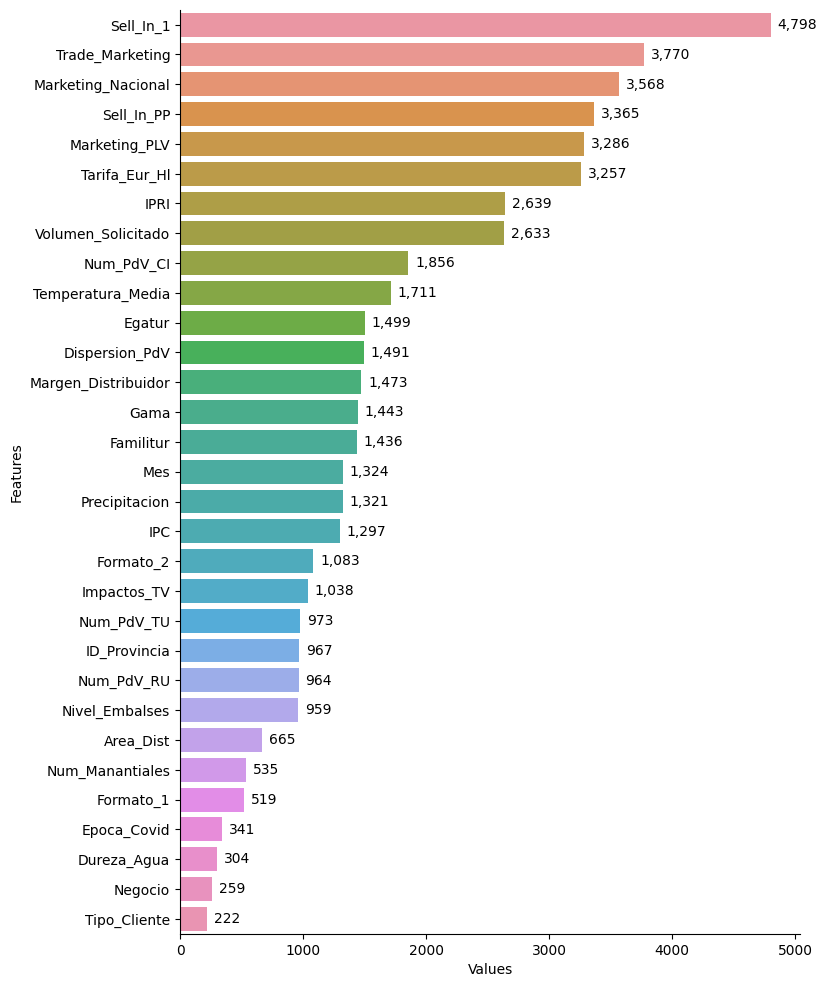

In [31]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_global)

### 3.2.2. Predicciones dataset de validación

In [30]:
# Datasets
print(f"Fechas totales: {dates_complete}")
print(f"Fechas entrenamiento: {dates_train}")
print(f"Fechas validación: {dates_val}")

Fechas totales: 72
Fechas entrenamiento: 69
Fechas validación: 3


In [31]:
# Fechas del dataset de validación
sorted(df_val['Fecha'].unique())

[202401, 202402, 202403]

In [32]:
# Dataset para comprobar predicciones
df_val.head()

,Fecha,Epoca_Covid,Anio,Mes,Negocio,Cliente,Tipo_Cliente,Codigo_Postal,Area_Dist,ID_Provincia,Provincia,ID_CCAA,Comunidad_Autonoma,Gama,Descripcion_Gama,Formato_1,Formato_2,Num_PdV_CI,Num_PdV_RU,Num_PdV_TU,Impactos_TV,Sell_In_PP,Marketing_Nacional,Trade_Marketing,Marketing_PLV,Dispersion_PdV,Volumen_Solicitado,Tarifa_Eur_Hl,Margen_Distribuidor,Egatur,Familitur,IPC,IPRI,Temperatura_Media,Precipitacion,Num_Manantiales,Nivel_Embalses,Dureza_Agua,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,202401,post-covid,2024,1,UNA,534689,DHC,28005,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 0,50 L",0,0,0,0,1,0,0,0,0,0,53,0,1161,0,0.0,116.099998,7.78,65.699997,0,68.980003,Media,4,3,2024-05-14T13:57:42.649Z,202404
1,202401,post-covid,2024,1,UNA,534689,DHC,28005,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 1,50 L",0,0,0,0,0,0,0,0,0,0,33,0,1161,0,0.0,116.099998,7.78,65.699997,0,68.980003,Media,0,0,2024-05-14T13:57:42.649Z,202404
2,202401,post-covid,2024,1,UNA,534690,DHC,28045,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 0,50 L",0,0,0,0,1,0,0,0,0,0,53,0,1161,0,0.0,116.099998,7.78,65.699997,0,68.980003,Media,3,3,2024-05-14T13:57:42.649Z,202404
3,202401,post-covid,2024,1,UNA,534691,DHC,28019,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 0,50 L",0,0,0,0,2,0,0,0,0,0,52,0,1161,0,0.0,116.099998,7.78,65.699997,0,68.980003,Media,3,3,2024-05-14T13:57:42.649Z,202404
4,202401,post-covid,2024,1,UNA,534691,DHC,28019,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 1,00 L",0,0,0,0,0,0,0,0,0,0,33,0,1161,0,0.0,116.099998,7.78,65.699997,0,68.980003,Media,0,0,2024-05-14T13:57:42.649Z,202404


In [33]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109587 entries, 0 to 109586
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Fecha                 109587 non-null  int32   
 1   Epoca_Covid           109587 non-null  category
 2   Anio                  109587 non-null  category
 3   Mes                   109587 non-null  category
 4   Negocio               109587 non-null  category
 5   Cliente               109587 non-null  category
 6   Tipo_Cliente          109587 non-null  category
 7   Codigo_Postal         109587 non-null  category
 8   Area_Dist             109587 non-null  category
 9   ID_Provincia          109587 non-null  category
 10  Provincia             109587 non-null  category
 11  ID_CCAA               109587 non-null  category
 12  Comunidad_Autonoma    109587 non-null  category
 13  Gama                  109587 non-null  category
 14  Descripcion_Gama      109587 non-nul

In [34]:
# Dataset de validación: df_val
# Modelo de MLflow: uri_lgb_global
# -----------------------------------------------------------------------------
df_analysis, metrics_val_global = execute_analysis(df_val, uri_lgb_global)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/e3bc49a39dab4b7284838aca19ec66b3/lightgbm-model-global




Métricas:
--------------------------------------------------
{
    "mae_val": 4.367,
    "score_val": 0.718
}


In [35]:
df_analysis.head()

,Negocio,Area_Dist,Formato_1,Formato_2,Formato,Sell_In,Sell_In_Pred,Desviacion_Vol,Desviacion_Pct
0,UNA,Y0,No retornable,GRAN FORMATO,No retornable - GRAN FORMATO,267,202.720818,64.28,-24.07
1,UNA,Y0,No retornable,Lata,No retornable - Lata,196,573.376670,377.38,192.54
2,UNA,Y0,No retornable,"PET 0,33 L","No retornable - PET 0,33 L",1005,864.873378,140.13,-13.94
3,UNA,Y0,No retornable,"PET 0,50 L","No retornable - PET 0,50 L",18834,18226.382228,607.62,-3.23
4,UNA,Y0,No retornable,"PET 0,75 L","No retornable - PET 0,75 L",1815,1636.504243,178.50,-9.83


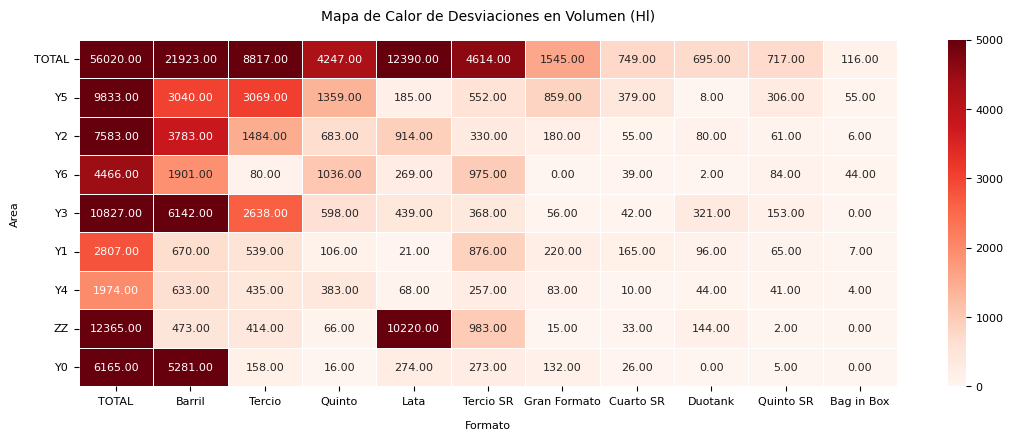

In [36]:
# Graficar mapa de calor de UNE de Volumen
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_vol(df_analysis, negocio='UNE', rango=5000)

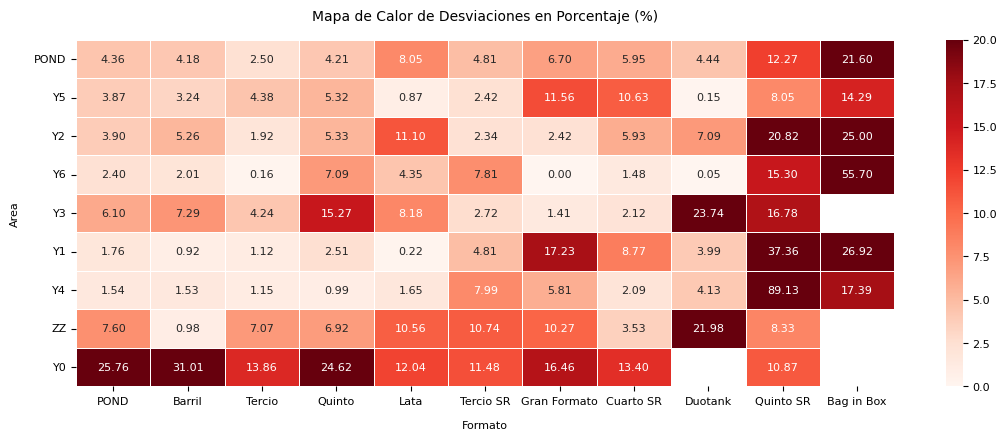

In [37]:
# Graficar mapa de calor de UNE
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_pct(df_analysis, negocio='UNE', rango=20)

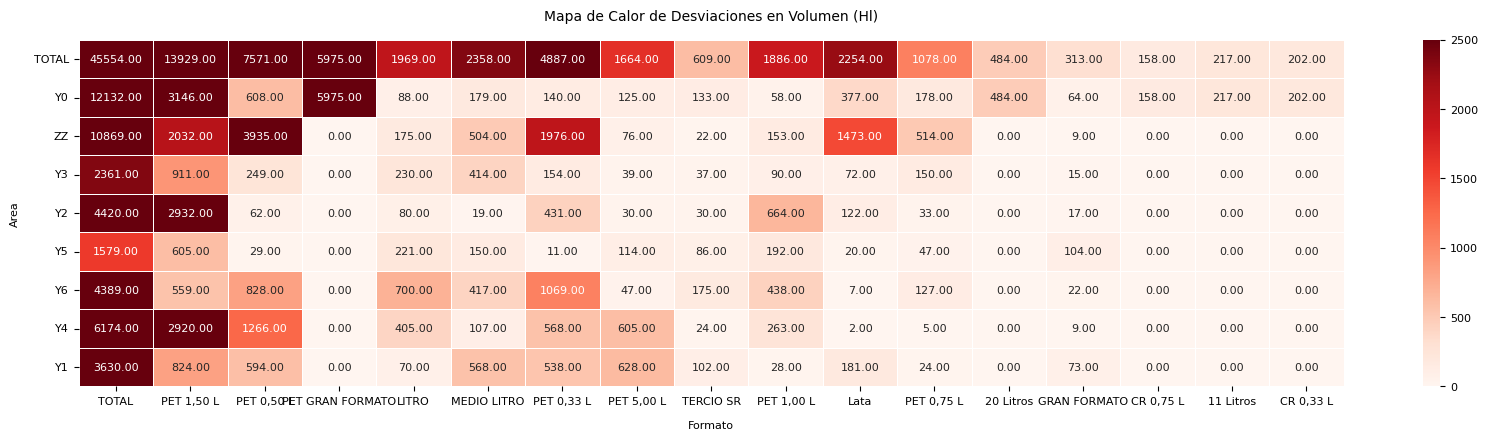

In [38]:
# Graficar mapa de calor de UNA de Volumen
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_vol(df_analysis, negocio='UNA', rango=2500)

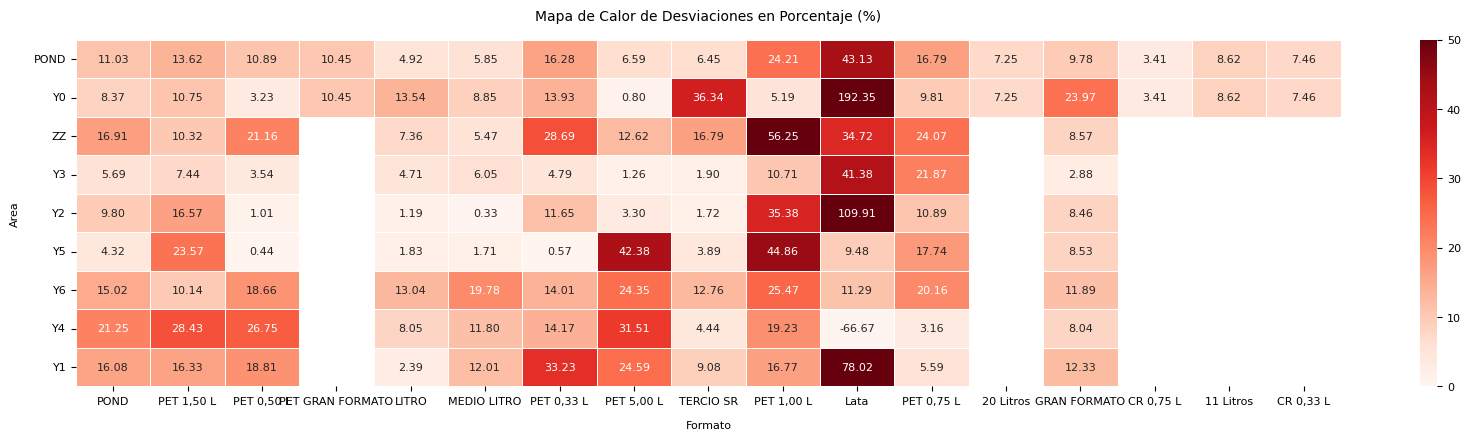

In [39]:
# Graficar mapa de calor de UNA
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_pct(df_analysis, negocio='UNA', rango=50)

## 3.3. LightGBM - Modelo UNE y UNA

El alcance de este experimento es:

**Modelo UNE:**
- Negocio: UNE
- Formatos: Todos

**Modelo UNA:**
- Negocio: UNA
- Formatos: Todos

### 3.3.1. Entrenamiento

#### 3.3.1.1. Modelo UNE

In [40]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE'
model_name = 'lightgbm-model-une'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por ...
filtro = df_exp.Negocio=='UNE'
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une, uri_lgb_une, metrics_une = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 2.9560182015101115 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: c0ef31c653204c64876abebd75ee3fe0 --> Modelo_LightGBM_Experiment_UNE
- Nombre del modelo: lightgbm-model-une

- URI del modelo: 'runs:/c0ef31c653204c64876abebd75ee3fe0/lightgbm-model-une'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


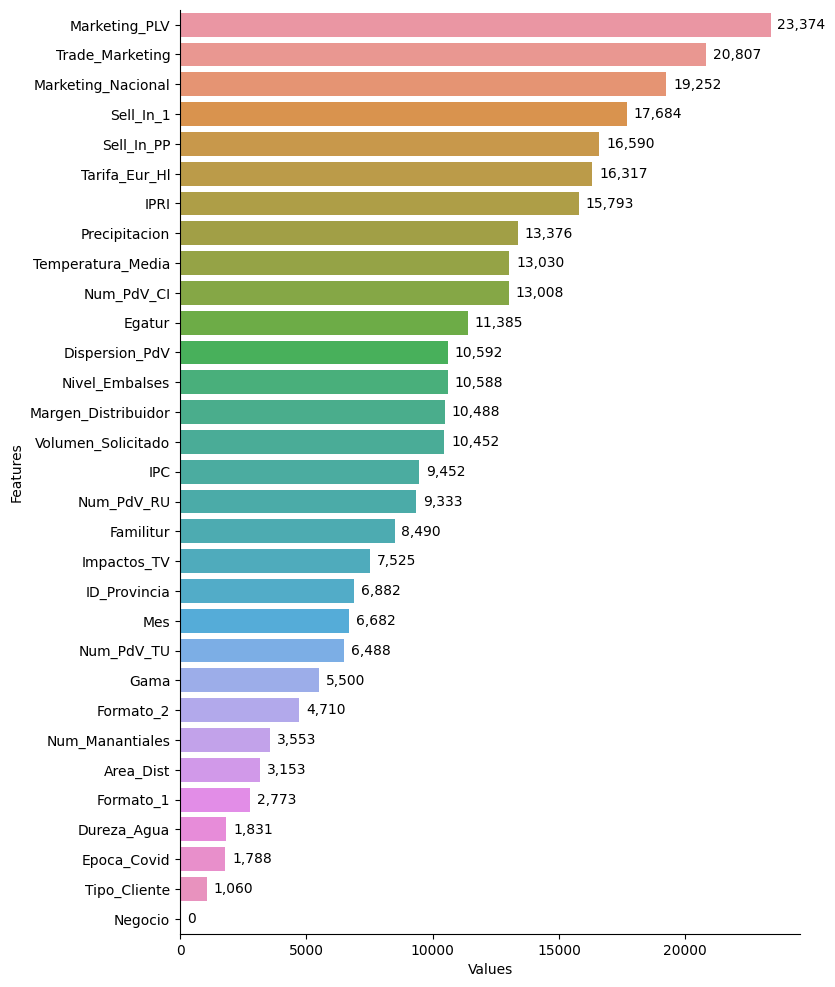

In [41]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_une)

#### 3.3.1.2. Modelo UNA

In [42]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA'
model_name = 'lightgbm-model-una'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por ...
filtro = df_exp.Negocio=='UNA'
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_una, uri_lgb_una, metrics_una = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.6612662355105082 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 1f42c9cb34894783a3ea2827e858cf34 --> Modelo_LightGBM_Experiment_UNA
- Nombre del modelo: lightgbm-model-una

- URI del modelo: 'runs:/1f42c9cb34894783a3ea2827e858cf34/lightgbm-model-una'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


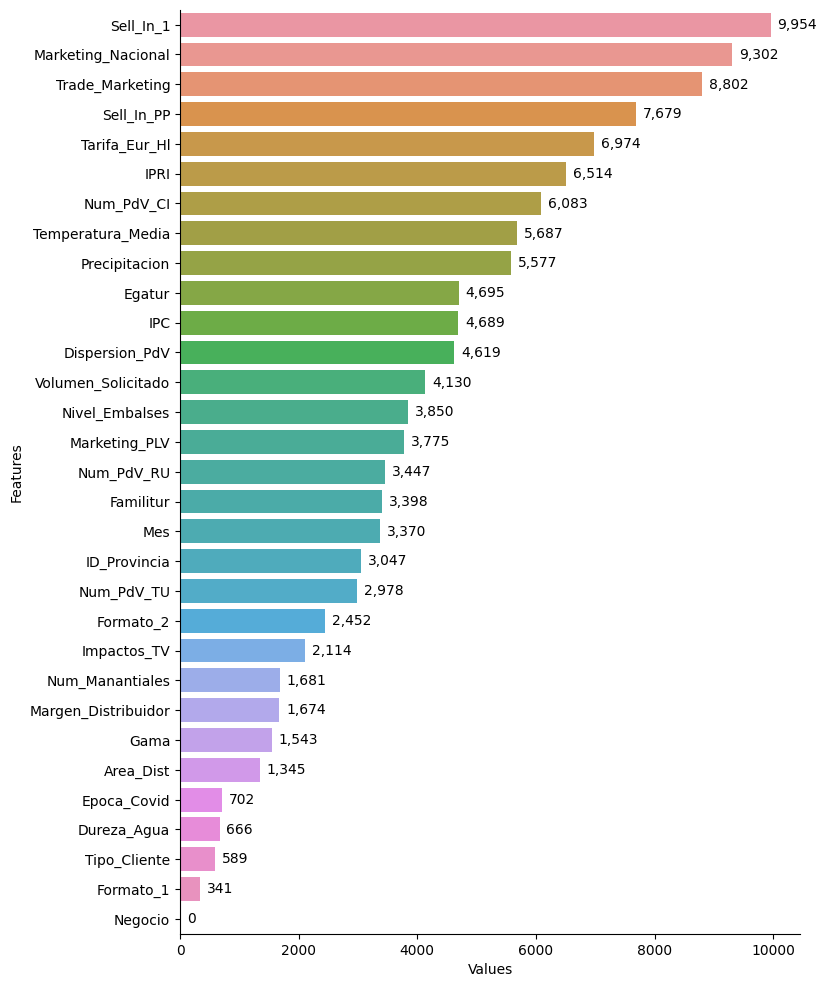

In [43]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_una)

### 3.3.2. Predicciones dataset de validación

In [44]:
# Modelo:
# -----------------------------------------------------------------------------
# uri_lgb_une

# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = df_val.Negocio=='UNE'
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une
# -----------------------------------------------------------------------------
df_analysis_une, metrics_val_une = execute_analysis(df_val_exp, uri_lgb_une)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/c0ef31c653204c64876abebd75ee3fe0/lightgbm-model-une




Métricas:
--------------------------------------------------
{
    "mae_val": 3.691,
    "score_val": 0.769
}


In [45]:
# Modelo:
# -----------------------------------------------------------------------------
# uri_lgb_una

# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = df_val.Negocio=='UNA'
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une
# -----------------------------------------------------------------------------
df_analysis_una, metrics_val_una = execute_analysis(df_val_exp, uri_lgb_una)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/1f42c9cb34894783a3ea2827e858cf34/lightgbm-model-una




Métricas:
--------------------------------------------------
{
    "mae_val": 6.339,
    "score_val": 0.555
}


In [46]:
# Concatenar los DataFrames
df_analysis = pd.concat([df_analysis_une, df_analysis_una], axis=0)

df_analysis.shape

(178, 9)

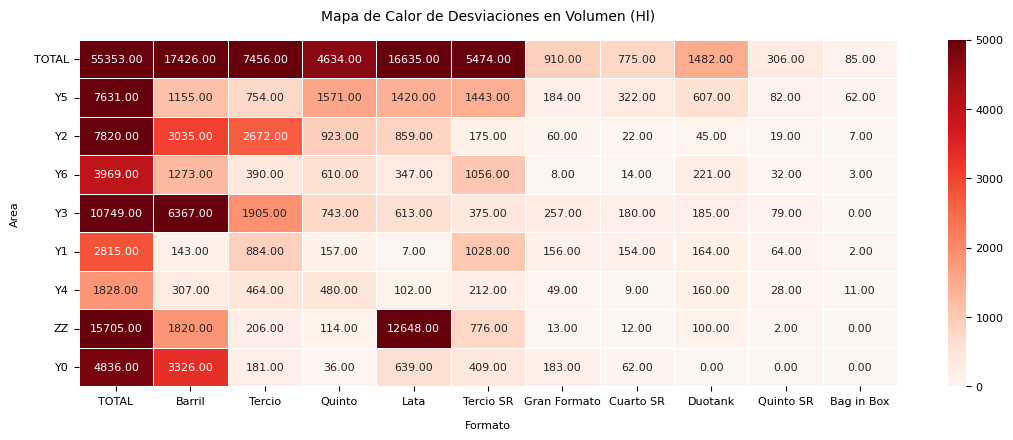

In [47]:
# Graficar mapa de calor de UNE de Volumen
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_vol(df_analysis, negocio='UNE', rango=5000)

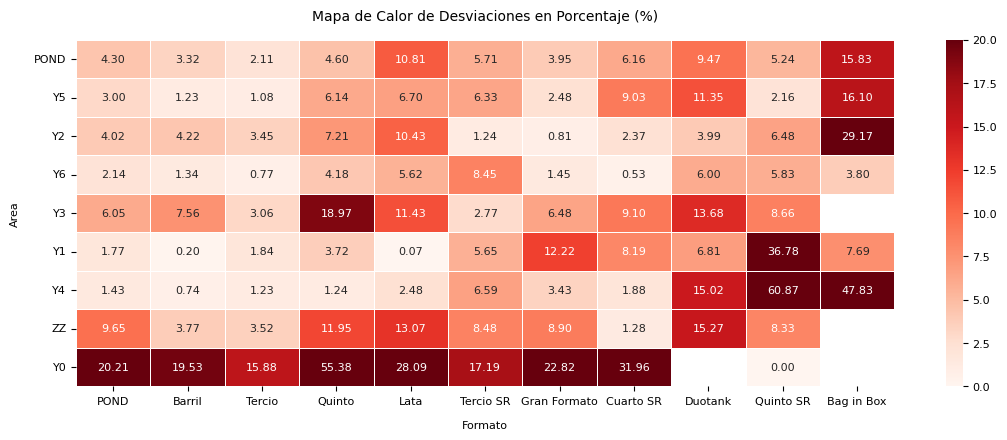

In [48]:
# Graficar mapa de calor de UNE en Porcentaje
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_pct(df_analysis, negocio='UNE', rango=20)

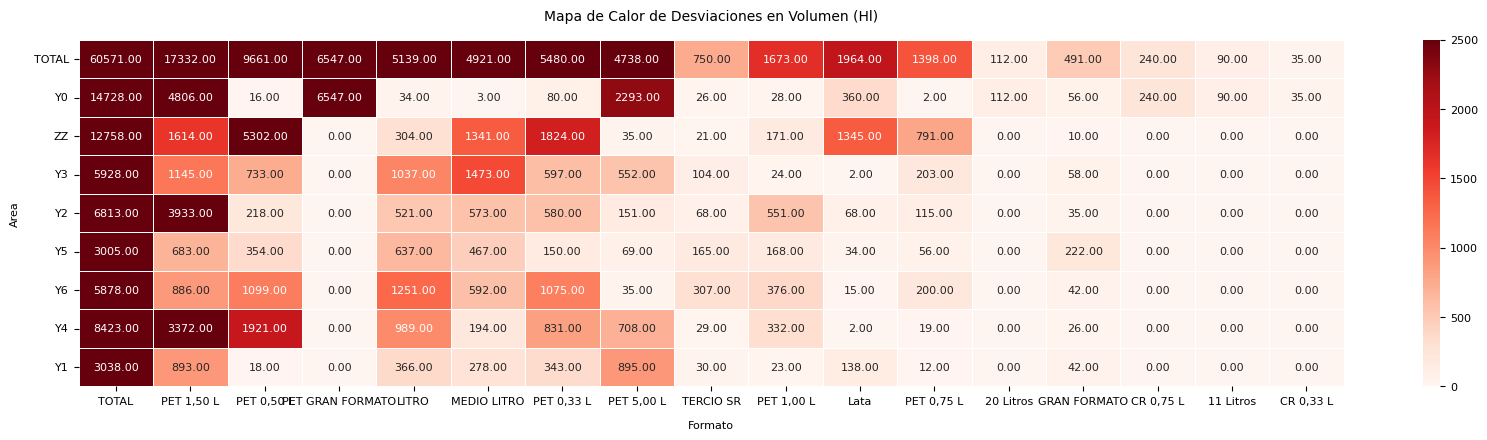

In [49]:
# Graficar mapa de calor de UNA de Volumen
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_vol(df_analysis, negocio='UNA', rango=2500)

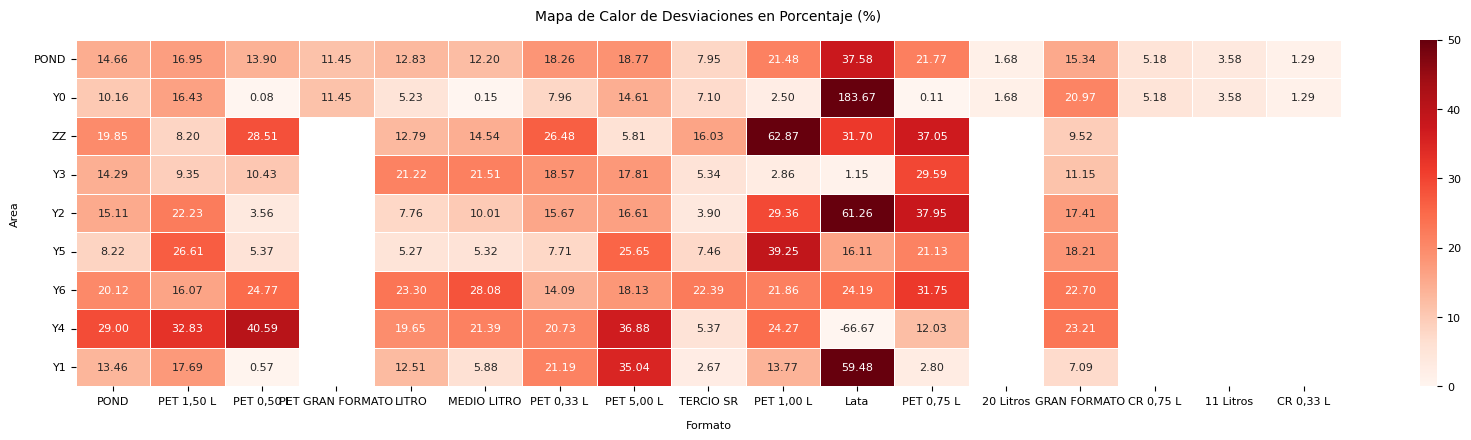

In [50]:
# Graficar mapa de calor de UNA en Porcentaje
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_pct(df_analysis, negocio='UNA', rango=50)

## 3.4. LightGBM - Modelo UNE (Formato_1) y UNA (Formato_1)

El alcance de este experimento es:

**Modelo UNE - Formato_1:**
- Negocio: UNE
- Formatos: Barril, Retornable y No retornbale

**Modelo UNA - Formato_1:**
- Negocio: UNA
- Formatos: Retornable y No retornbale

### 3.4.1. Entrenamiento

#### 3.4.1.1. Modelo UNE-Barril

In [51]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_Barril'
model_name = 'lightgbm-model-une-barril'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='Barril')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une_barril, uri_lgb_une_barril, metrics_une_barril = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.553056542078654 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 37c48e3f9d0f45c1b5e2c81a01dcd521 --> Modelo_LightGBM_Experiment_UNE_Barril
- Nombre del modelo: lightgbm-model-une-barril

- URI del modelo: 'runs:/37c48e3f9d0f45c1b5e2c81a01dcd521/lightgbm-model-une-barril'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
 

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


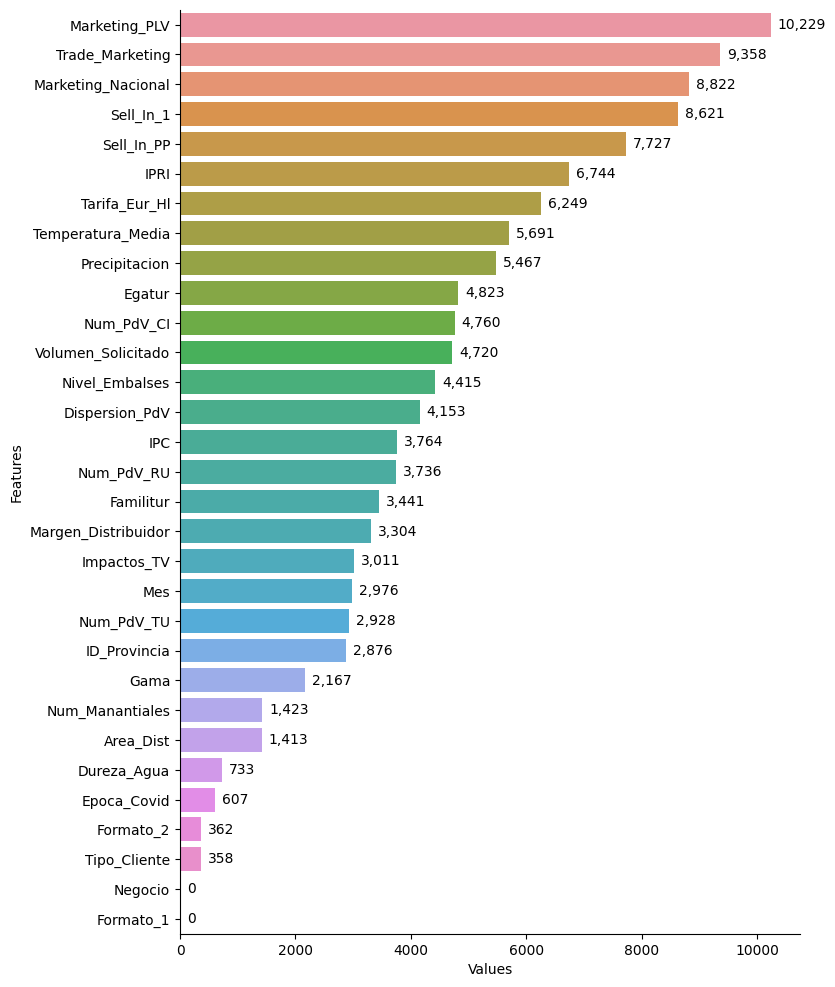

In [52]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_une_barril)

#### 3.4.1.2. Modelo UNE-Retornable

In [53]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_Ret'
model_name = 'lightgbm-model-une-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='Retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une_ret, uri_lgb_une_ret, metrics_une_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.5900737841924032 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: de00b73a8508438e888711b1023aef53 --> Modelo_LightGBM_Experiment_UNE_Ret
- Nombre del modelo: lightgbm-model-une-ret

- URI del modelo: 'runs:/de00b73a8508438e888711b1023aef53/lightgbm-model-une-ret'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_es

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


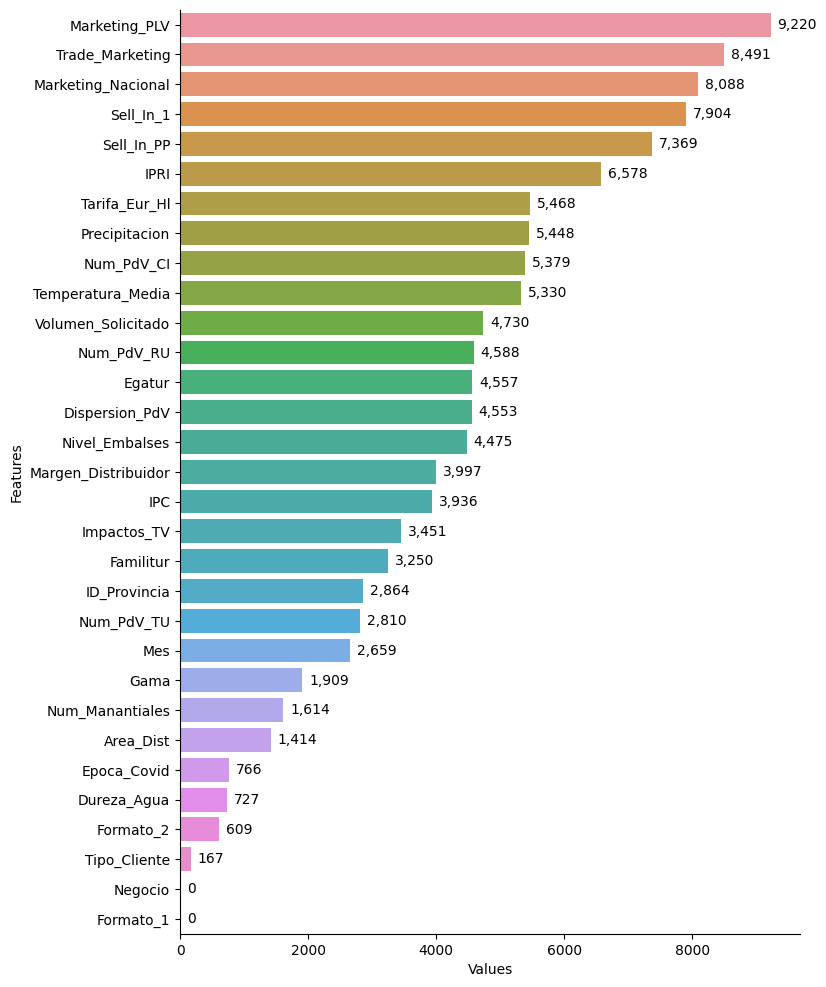

In [54]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_une_ret)

#### 3.4.1.3. Modelo UNE-No retornable

In [55]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_No_Ret'
model_name = 'lightgbm-model-une-no-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='No retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une_no_ret, uri_lgb_une_no_ret, metrics_une_no_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 1.783244792620341 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 9cb674ad0d0342ce82411a15f38edf40 --> Modelo_LightGBM_Experiment_UNE_No_Ret
- Nombre del modelo: lightgbm-model-une-no-ret

- URI del modelo: 'runs:/9cb674ad0d0342ce82411a15f38edf40/lightgbm-model-une-no-ret'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
 

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [56]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_No_Ret'
model_name = 'lightgbm-model-une-no-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='No retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une_no_ret, uri_lgb_une_no_ret, metrics_une_no_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 1.3108994682629904 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 835a4f5cbffc4a6ba2dddf5faadc2e85 --> Modelo_LightGBM_Experiment_UNE_No_Ret
- Nombre del modelo: lightgbm-model-une-no-ret

- URI del modelo: 'runs:/835a4f5cbffc4a6ba2dddf5faadc2e85/lightgbm-model-une-no-ret'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,


/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


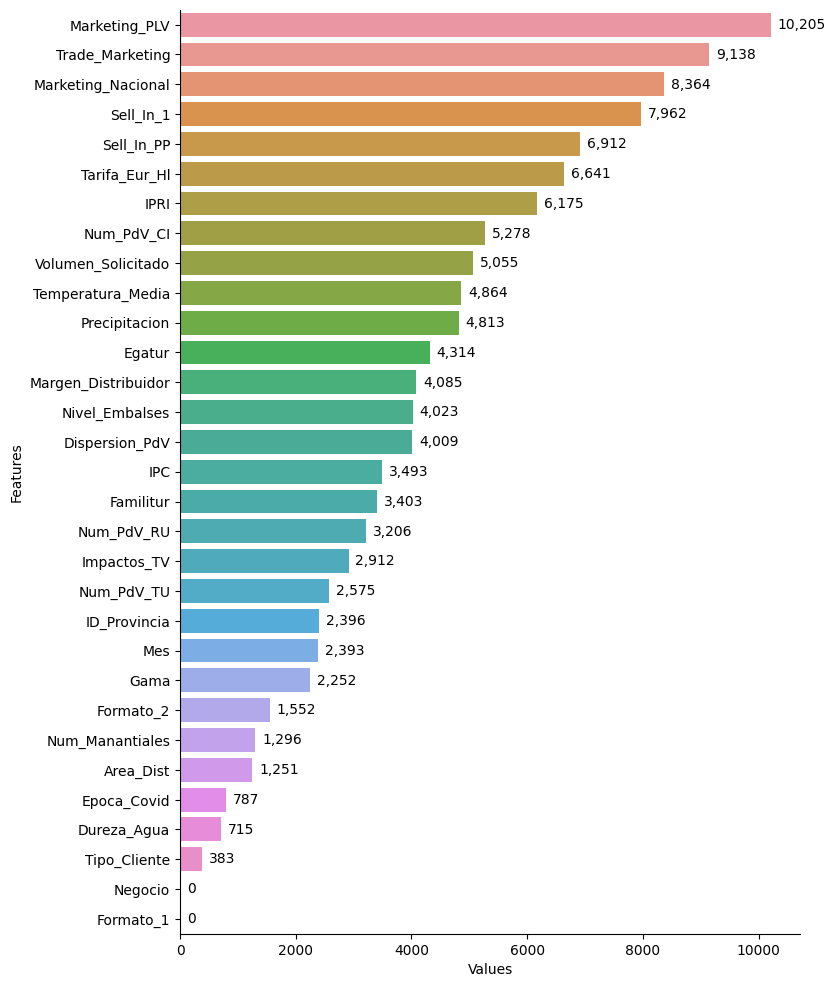

In [57]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_une_no_ret)

#### 3.4.1.4. Modelo UNA-Retornable

In [58]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_Ret'
model_name = 'lightgbm-model-una-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='Retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 150,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_una_ret, uri_lgb_una_ret, metrics_una_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.1519009788831075 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: da3c20bfd3e64e1c8c700125ea2cb7c4 --> Modelo_LightGBM_Experiment_UNA_Ret
- Nombre del modelo: lightgbm-model-una-ret

- URI del modelo: 'runs:/da3c20bfd3e64e1c8c700125ea2cb7c4/lightgbm-model-una-ret'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_es

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


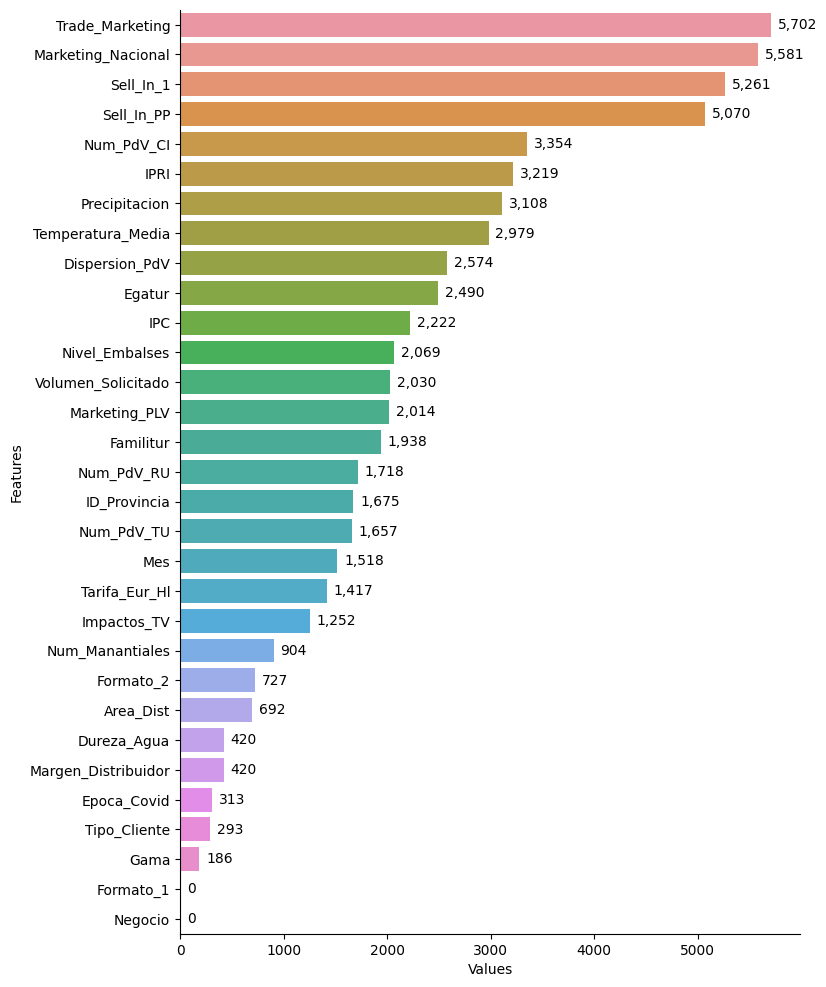

In [59]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_una_ret)

#### 3.4.1.5. Modelo UNA-No retornable

In [60]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_No_Ret'
model_name = 'lightgbm-model-una-no-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='No retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_una_no_ret, uri_lgb_una_no_ret, metrics_una_no_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.5491853356361389 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 3eff955aec794111af15c07f9bbf7d2b --> Modelo_LightGBM_Experiment_UNA_No_Ret
- Nombre del modelo: lightgbm-model-una-no-ret

- URI del modelo: 'runs:/3eff955aec794111af15c07f9bbf7d2b/lightgbm-model-una-no-ret'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,


/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


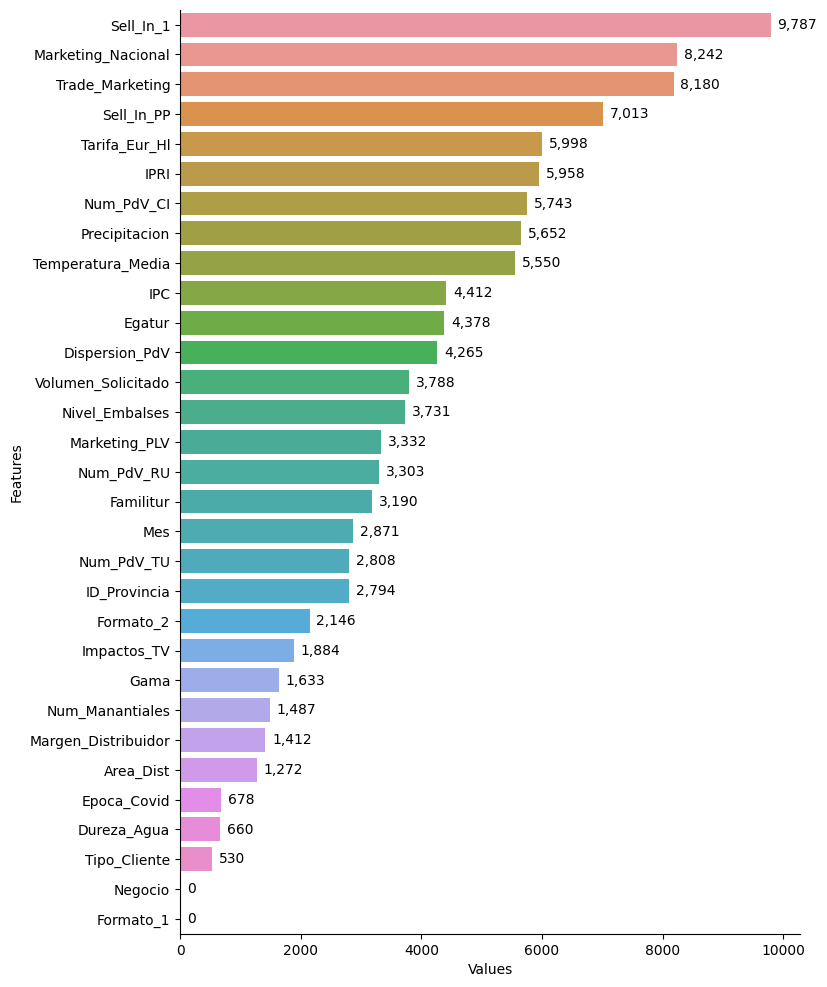

In [61]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_una_no_ret)

### 3.4.2. Predicciones dataset de validación

In [62]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='Barril')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_barril
# -----------------------------------------------------------------------------
df_analysis_une_barril, metrics_val_une_barril = execute_analysis(df_val_exp, uri_lgb_une_barril)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/37c48e3f9d0f45c1b5e2c81a01dcd521/lightgbm-model-une-barril




Métricas:
--------------------------------------------------
{
    "mae_val": 7.868,
    "score_val": 0.748
}


In [63]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='Retornable')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_ret
# -----------------------------------------------------------------------------
df_analysis_une_ret, metrics_val_une_ret = execute_analysis(df_val_exp, uri_lgb_une_ret)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/de00b73a8508438e888711b1023aef53/lightgbm-model-une-ret




Métricas:
--------------------------------------------------
{
    "mae_val": 4.551,
    "score_val": 0.817
}


In [64]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='No retornable')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_no_ret
# -----------------------------------------------------------------------------
df_analysis_une_no_ret, metrics_val_une_no_ret = execute_analysis(df_val_exp, uri_lgb_une_no_ret)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/835a4f5cbffc4a6ba2dddf5faadc2e85/lightgbm-model-une-no-ret




Métricas:
--------------------------------------------------
{
    "mae_val": 2.018,
    "score_val": 0.689
}


In [65]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='Retornable')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_ret
# -----------------------------------------------------------------------------
df_analysis_una_ret, metrics_val_una_ret = execute_analysis(df_val_exp, uri_lgb_una_ret)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/da3c20bfd3e64e1c8c700125ea2cb7c4/lightgbm-model-una-ret




Métricas:
--------------------------------------------------
{
    "mae_val": 4.868,
    "score_val": 0.686
}


In [66]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='No retornable')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_no_ret
# -----------------------------------------------------------------------------
df_analysis_una_no_ret, metrics_val_una_no_ret = execute_analysis(df_val_exp, uri_lgb_una_no_ret)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/3eff955aec794111af15c07f9bbf7d2b/lightgbm-model-una-no-ret




Métricas:
--------------------------------------------------
{
    "mae_val": 6.618,
    "score_val": 0.523
}


In [67]:
# Concatenar los DataFrames
df_analysis = pd.concat([
    df_analysis_une_barril,
    df_analysis_une_ret,
    df_analysis_une_no_ret,
    #df_analysis_una_barril,
    df_analysis_una_ret,
    df_analysis_una_no_ret
], axis=0)

df_analysis.shape

(178, 9)

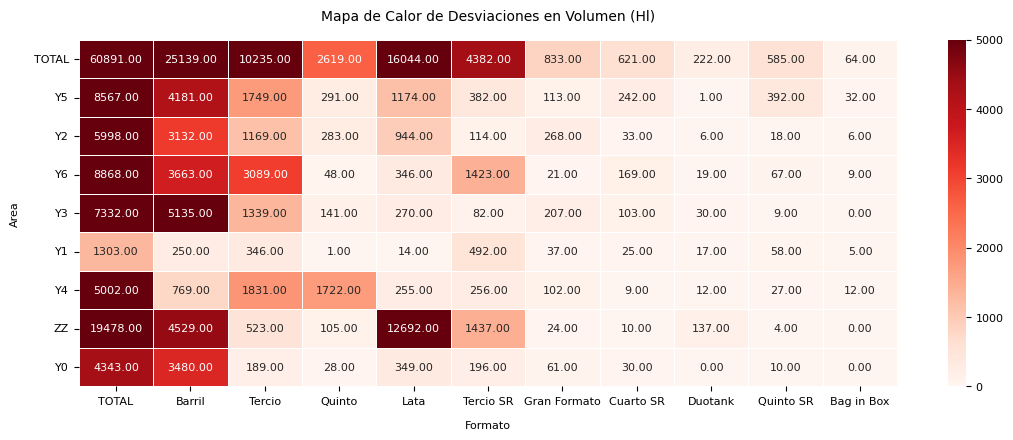

In [68]:
# Graficar mapa de calor de UNE de Volumen
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_vol(df_analysis, negocio='UNE', rango=5000)

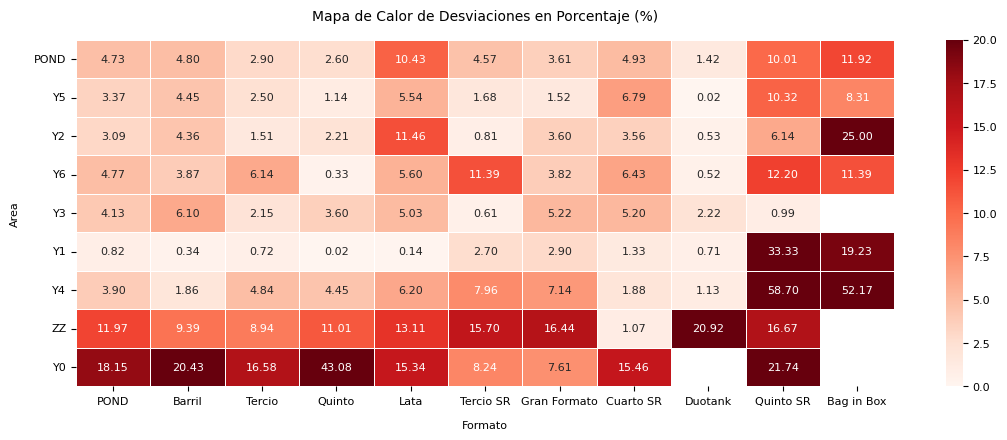

In [69]:
# Graficar mapa de calor de UNE en Porcentaje
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_pct(df_analysis, negocio='UNE', rango=20)

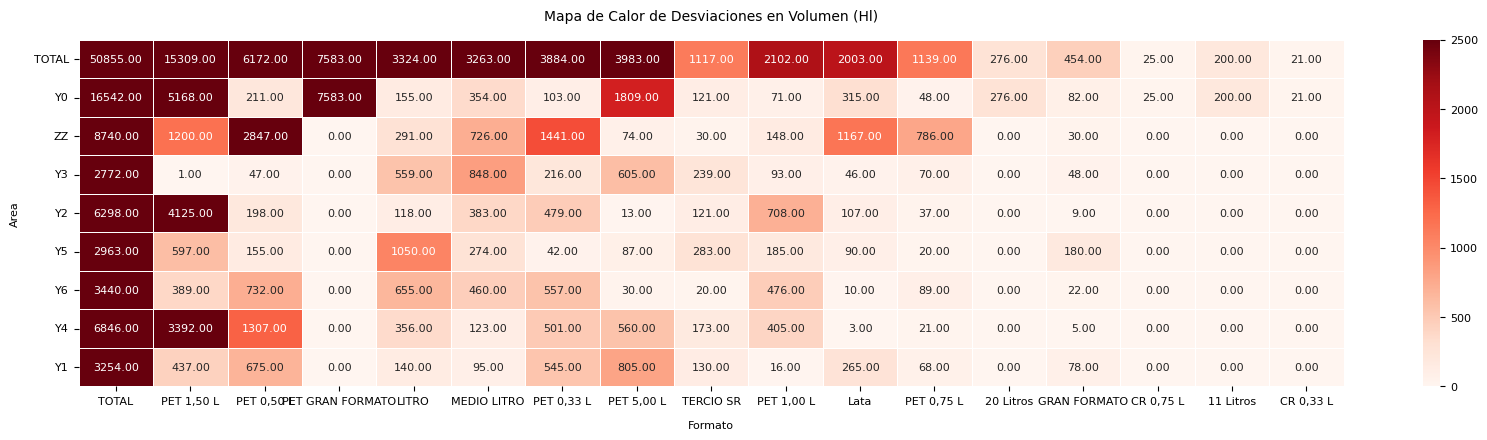

In [70]:
# Graficar mapa de calor de UNA de Volumen
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_vol(df_analysis, negocio='UNA', rango=2500)

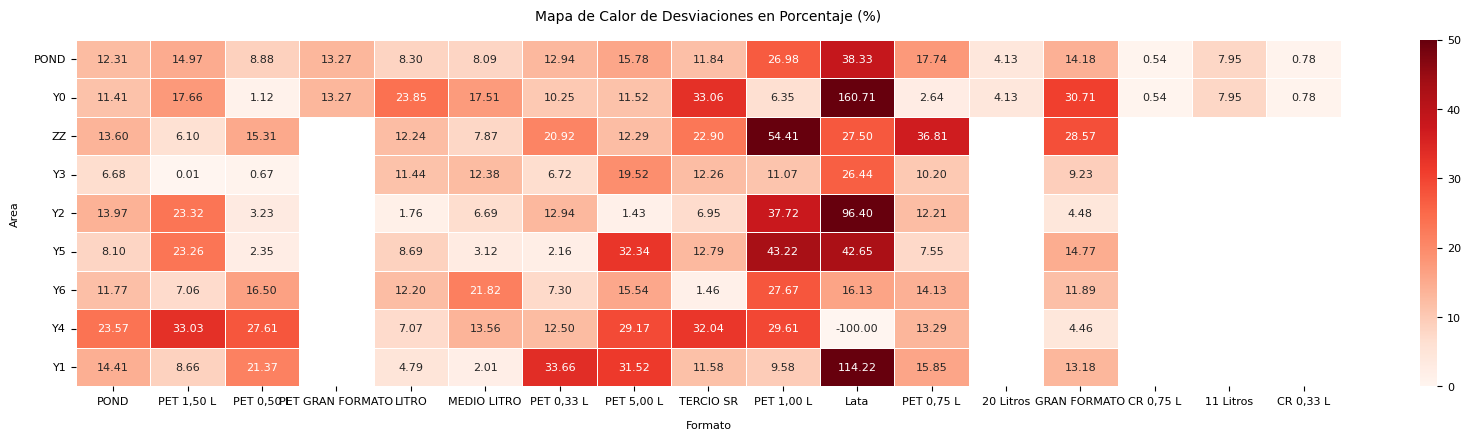

In [71]:
# Graficar mapa de calor de UNA en Porcentaje
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_pct(df_analysis, negocio='UNA', rango=50)

## 3.5. LightGBM - Modelo UNE (Formato_2) y UNA (Formato_2)

El alcance de este experimento es:

**Modelo UNE - Formato_1:**
- Negocio: UNE
- Formatos: Barril, Tercio, Quinto, Tercio SR, y global para resto

**Modelo UNA - Formato_1:**
- Negocio: UNA
- Formatos: PET 1,50 L, PET 0,50 L, LITRO, MEDIO LITRO

### 3.5.1. Entrenamiento

#### 3.5.1.1. Modelo UNE-Barril

In [72]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_Barril_Barril'
model_name = 'lightgbm-model-une-barril-barril'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='Barril') & (df_exp.Formato_2=='Barril')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une_barril_barril, uri_lgb_une_barril_barril, metrics_une_barril_barril = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.5442306518554687 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: ec27a084bbfc4646a6256c0282730968 --> Modelo_LightGBM_Experiment_UNE_Barril_Barril
- Nombre del modelo: lightgbm-model-une-barril-barril

- URI del modelo: 'runs:/ec27a084bbfc4646a6256c0282730968/lightgbm-model-une-barril-barril'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


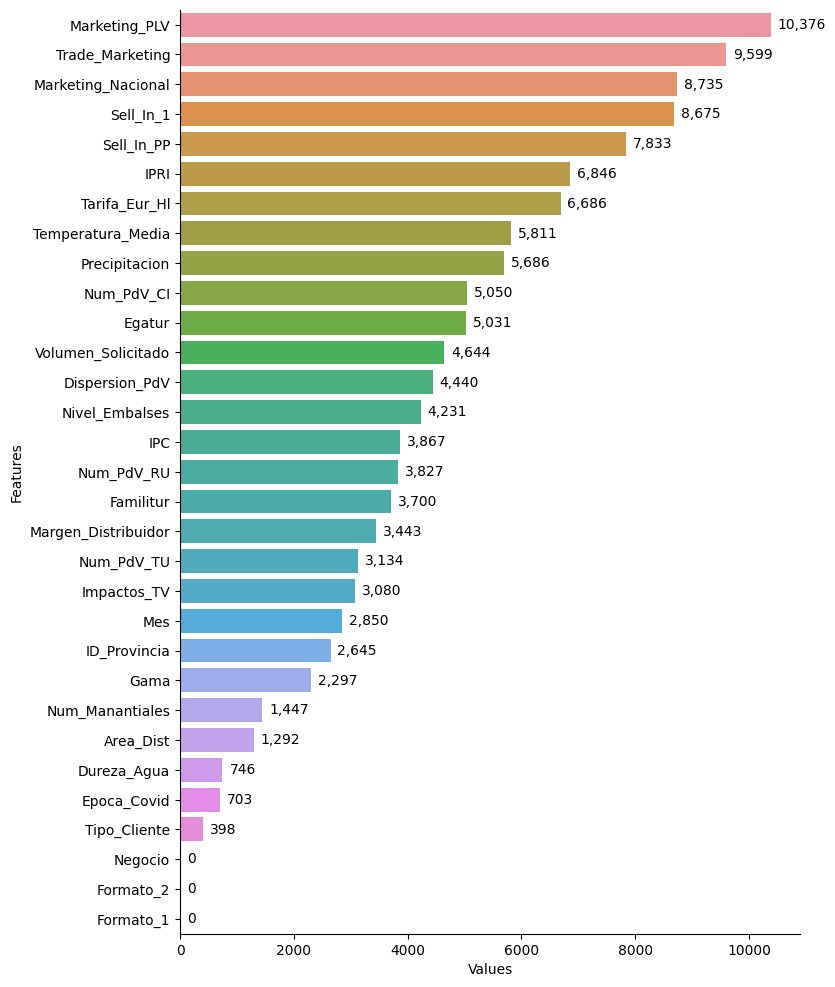

In [73]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_une_barril_barril)

#### 3.5.1.2. Modelo UNE-Tercio

In [74]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_Ret_Tercio'
model_name = 'lightgbm-model-une-ret-tercio'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='Retornable') & (df_exp.Formato_2=='Tercio')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une_ret_tercio, uri_lgb_une_ret_tercio, metrics_une_ret_tercio = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.4310012658437093 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 1d1ea31eae4f4718bfc5ee48b4f00956 --> Modelo_LightGBM_Experiment_UNE_Ret_Tercio
- Nombre del modelo: lightgbm-model-une-ret-tercio

- URI del modelo: 'runs:/1d1ea31eae4f4718bfc5ee48b4f00956/lightgbm-model-une-ret-tercio'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


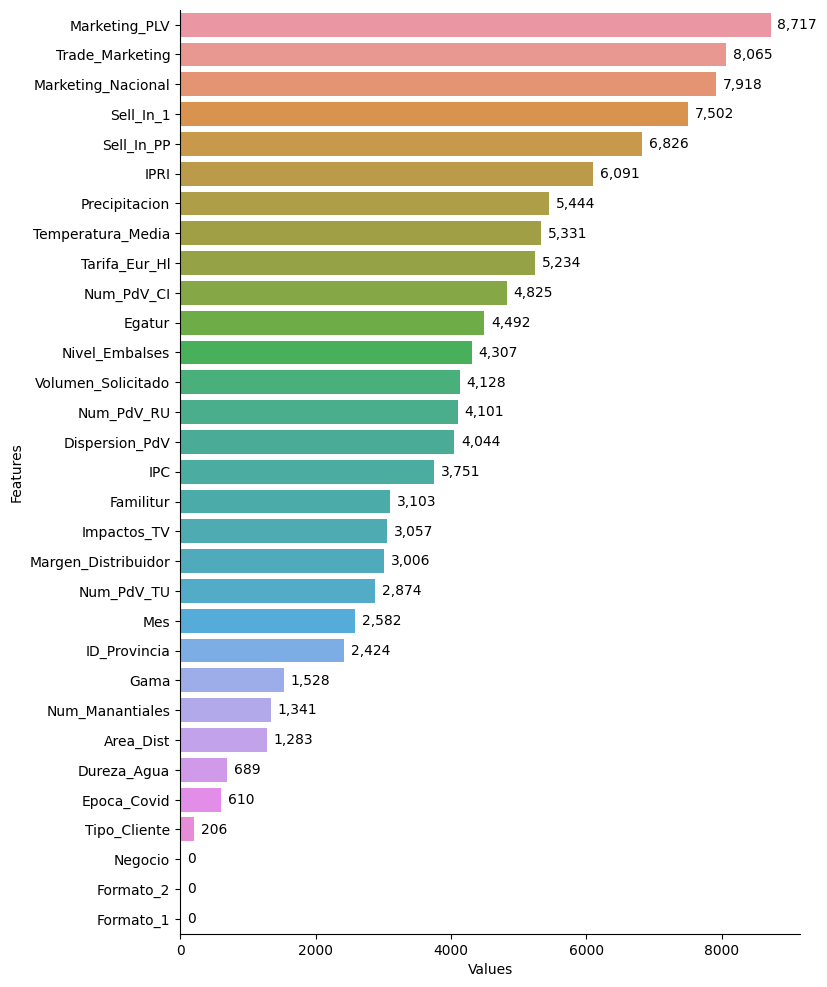

In [75]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_une_ret_tercio)

#### 3.5.1.3. Modelo UNE-Quinto

In [76]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_Ret_Quinto'
model_name = 'lightgbm-model-une-ret-quinto'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='Retornable') & (df_exp.Formato_2=='Quinto')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une_ret_quinto, uri_lgb_une_ret_quinto, metrics_une_ret_quinto = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.21334757407506308 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 1713512f983541f9a55e5d5bf1413920 --> Modelo_LightGBM_Experiment_UNE_Ret_Quinto
- Nombre del modelo: lightgbm-model-une-ret-quinto

- URI del modelo: 'runs:/1713512f983541f9a55e5d5bf1413920/lightgbm-model-une-ret-quinto'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


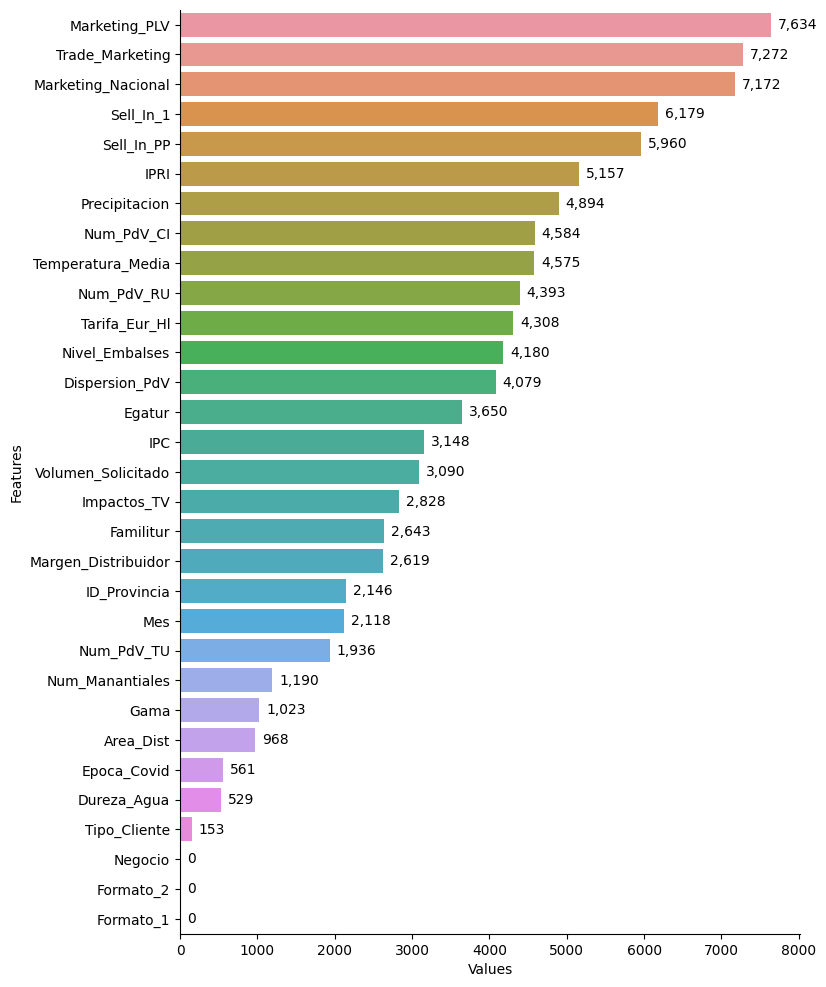

In [77]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_une_ret_quinto)

#### 3.5.1.4. Modelo UNE-Tercio SR

In [78]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_No_Ret_TercioSR'
model_name = 'lightgbm-model-une-no-ret-terciosr'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='No retornable') & (df_exp.Formato_2=='Tercio SR')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_une_no_ret_terciosr, uri_lgb_une_no_ret_terciosr, metrics_une_no_ret_terciosr = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.6664592226346334 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: b551af0eb0d744e48483fbd30f76c496 --> Modelo_LightGBM_Experiment_UNE_No_Ret_TercioSR
- Nombre del modelo: lightgbm-model-une-no-ret-terciosr

- URI del modelo: 'runs:/b551af0eb0d744e48483fbd30f76c496/lightgbm-model-une-no-ret-terciosr'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


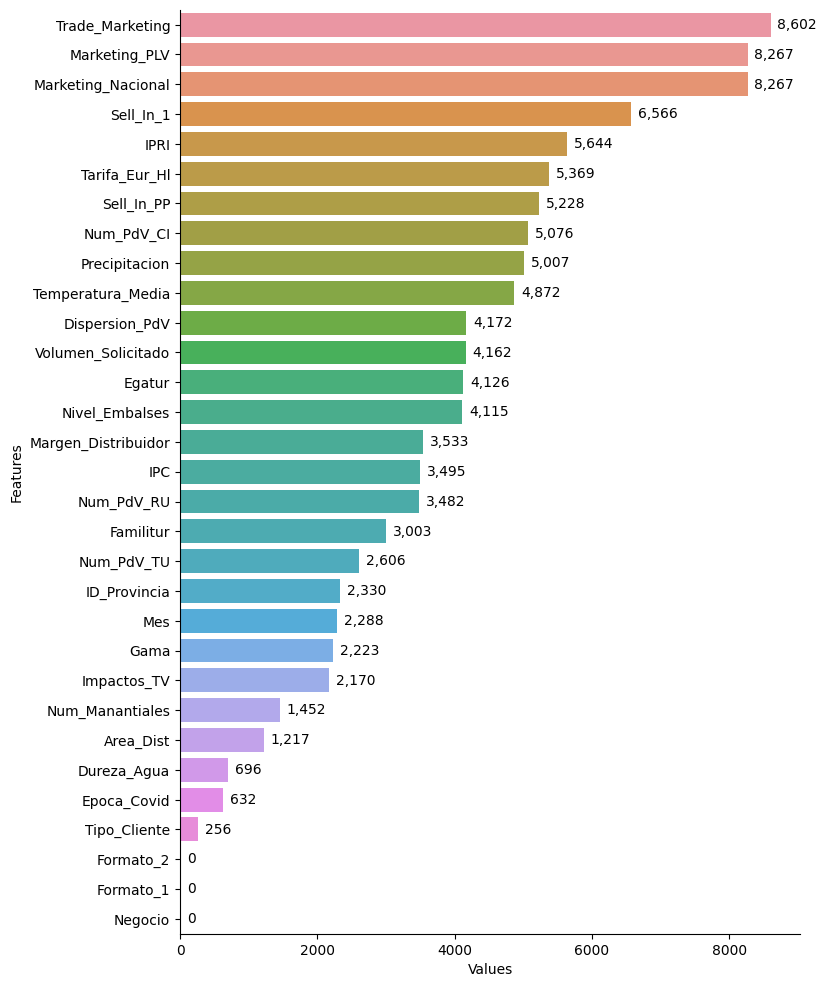

In [79]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_une_no_ret_terciosr)

#### 3.5.1.5. Modelo UNA-PET 1,50 L

In [80]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_No_Ret_Pet_1_5'
model_name = 'lightgbm-model-una-no-ret-pet-1_5'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='No retornable') & (df_exp.Formato_2=='PET 1,50 L')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_una_no_ret_pet_1_5, uri_lgb_una_no_ret_pet_1_5, metrics_una_no_ret_pet_1_5 = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.13232980569203695 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 3f9eaa1c96244ce7924c3d1f187f1fa3 --> Modelo_LightGBM_Experiment_UNA_No_Ret_Pet_1_5
- Nombre del modelo: lightgbm-model-una-no-ret-pet-1_5

- URI del modelo: 'runs:/3f9eaa1c96244ce7924c3d1f187f1fa3/lightgbm-model-una-no-ret-pet-1_5'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
 

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


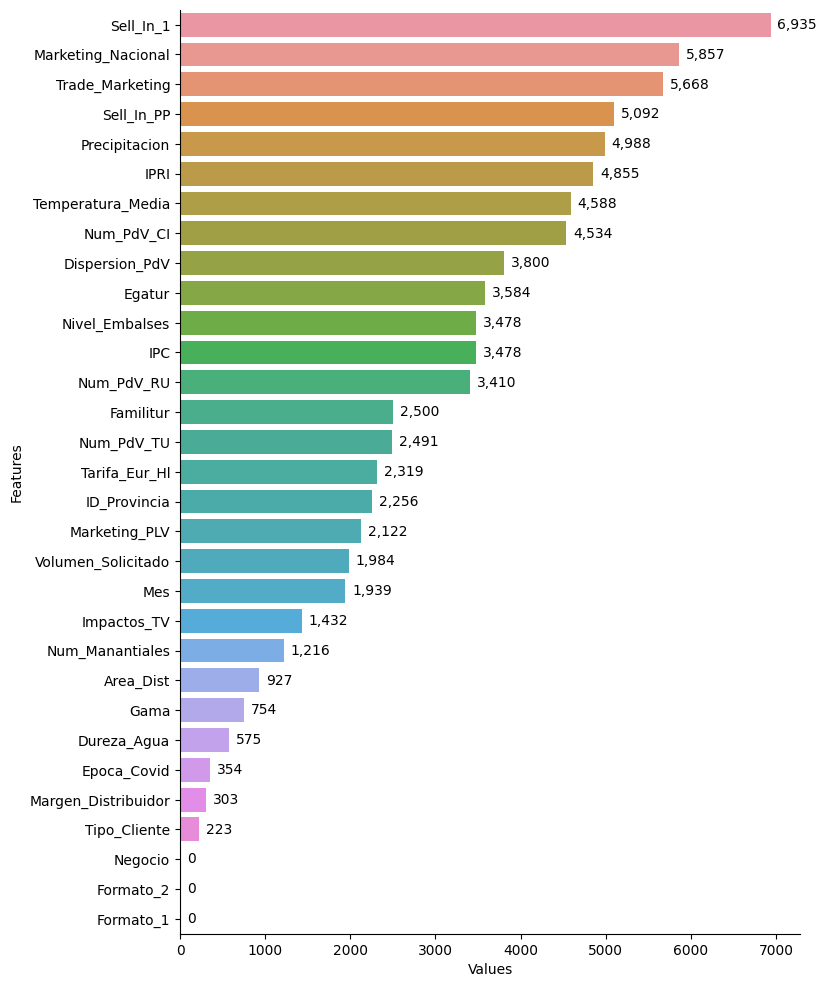

In [81]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_una_no_ret_pet_1_5)

#### 3.5.1.6. Modelo UNA-PET 0,50 L

In [82]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_No_Ret_Pet_0_5'
model_name = 'lightgbm-model-una-no-ret-pet-0_5'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='No retornable') & (df_exp.Formato_2=='PET 0,50 L')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_una_no_ret_pet_0_5, uri_lgb_una_no_ret_pet_0_5, metrics_una_no_ret_pet_0_5 = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.17134497165679932 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 2b971823d9754e8bbf5994dedfeaff06 --> Modelo_LightGBM_Experiment_UNA_No_Ret_Pet_0_5
- Nombre del modelo: lightgbm-model-una-no-ret-pet-0_5

- URI del modelo: 'runs:/2b971823d9754e8bbf5994dedfeaff06/lightgbm-model-una-no-ret-pet-0_5'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
 

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


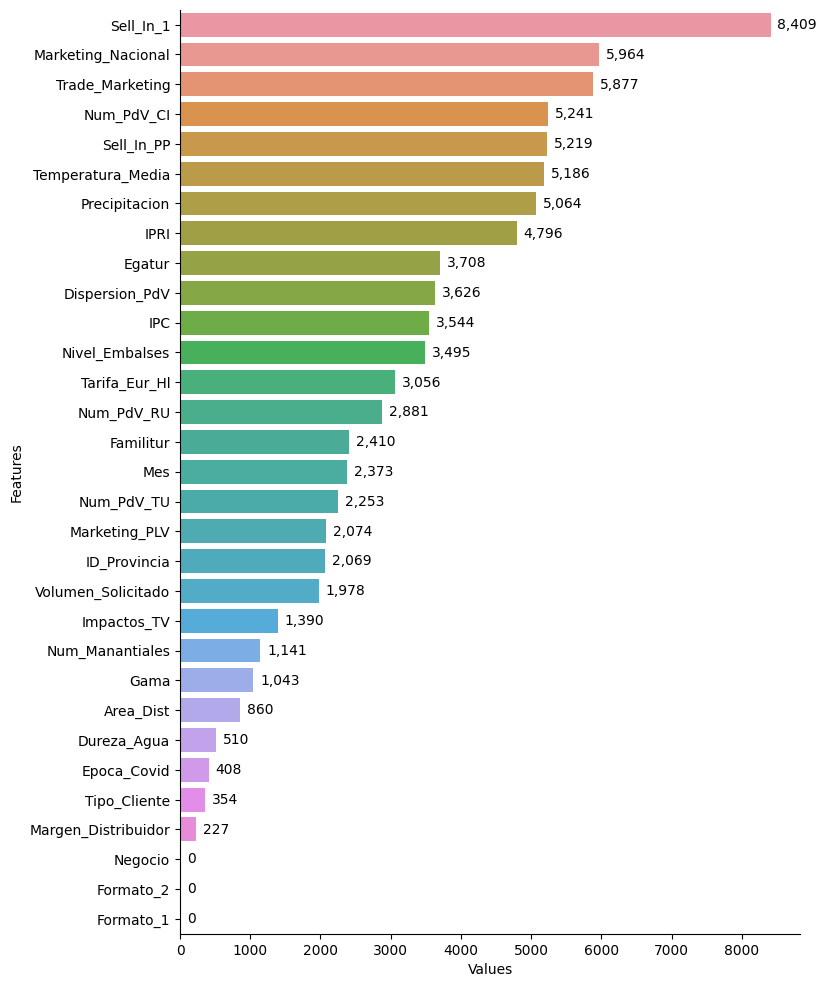

In [83]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_una_no_ret_pet_0_5)

#### 3.5.1.7. Modelo UNA-LITRO

In [133]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_Ret_Litro'
model_name = 'lightgbm-model-una-ret-litro'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='Retornable') & (df_exp.Formato_2=='LITRO')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_una_ret_litro, uri_lgb_una_ret_litro, metrics_una_ret_litro = execute_model(df_exp, seed, model_params)



Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.07912147839864095 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: f1f3c2f473f640948db4fdc419104aa6 --> Modelo_LightGBM_Experiment_UNA_Ret_Litro
- Nombre del modelo: lightgbm-model-una-ret-litro

- URI del modelo: 'runs:/f1f3c2f473f640948db4fdc419104aa6/lightgbm-model-una-ret-litro'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": true,
    "feature_pre_filter": false,
    "random_state": 123,
    "n_jobs": -1
}


Métricas:
-------------------------------------------------

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


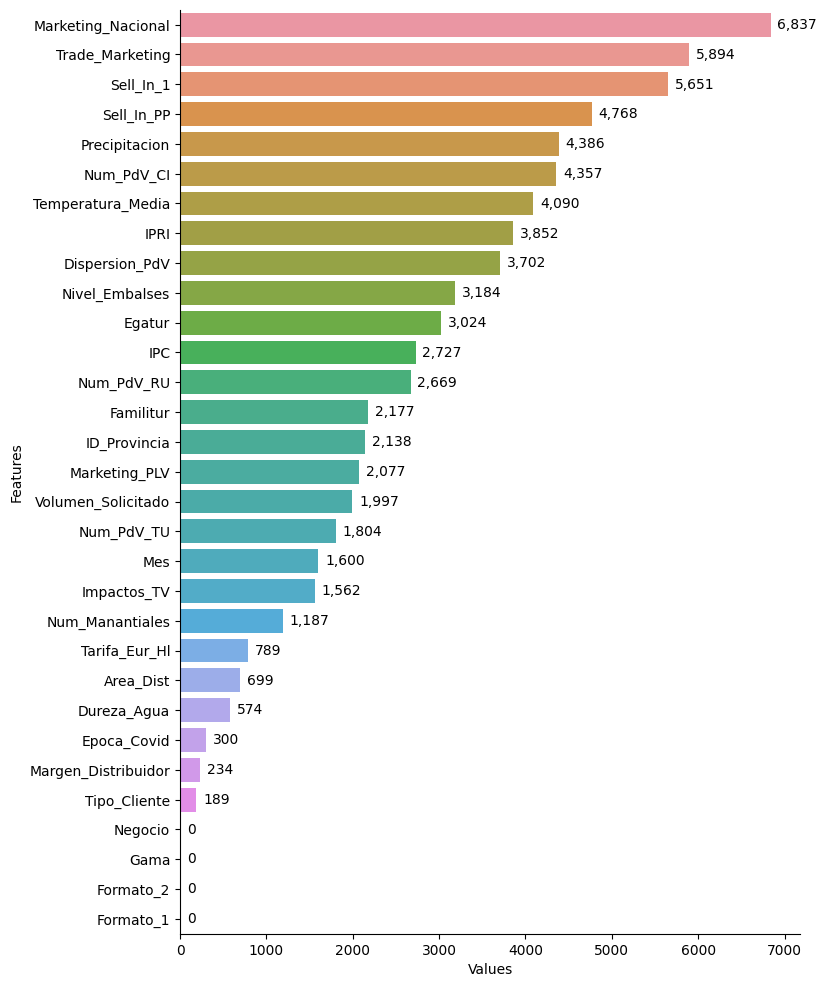

In [134]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_una_ret_litro)

#### 3.5.1.8. Modelo UNA-MEDIO LITRO

In [136]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_Ret_Medio_Litro'
model_name = 'lightgbm-model-una-ret-medio-litro'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='Retornable') & (df_exp.Formato_2=='MEDIO LITRO')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
lgb_una_ret_medio_litro, uri_lgb_una_ret_medio_litro, metrics_una_ret_medio_litro = execute_model(df_exp, seed, model_params)



Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.11308961709340414 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: bebc49b3da77488f83bbc3129584bc13 --> Modelo_LightGBM_Experiment_UNA_Ret_Medio_Litro
- Nombre del modelo: lightgbm-model-una-ret-medio-litro

- URI del modelo: 'runs:/bebc49b3da77488f83bbc3129584bc13/lightgbm-model-una-ret-medio-litro'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 8,
    "num_leaves": 200,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": true,
    "feature_pre_filter": false,
    "random_state": 123,
    "n_jobs": -1
}


Métricas:
-------------------------------

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


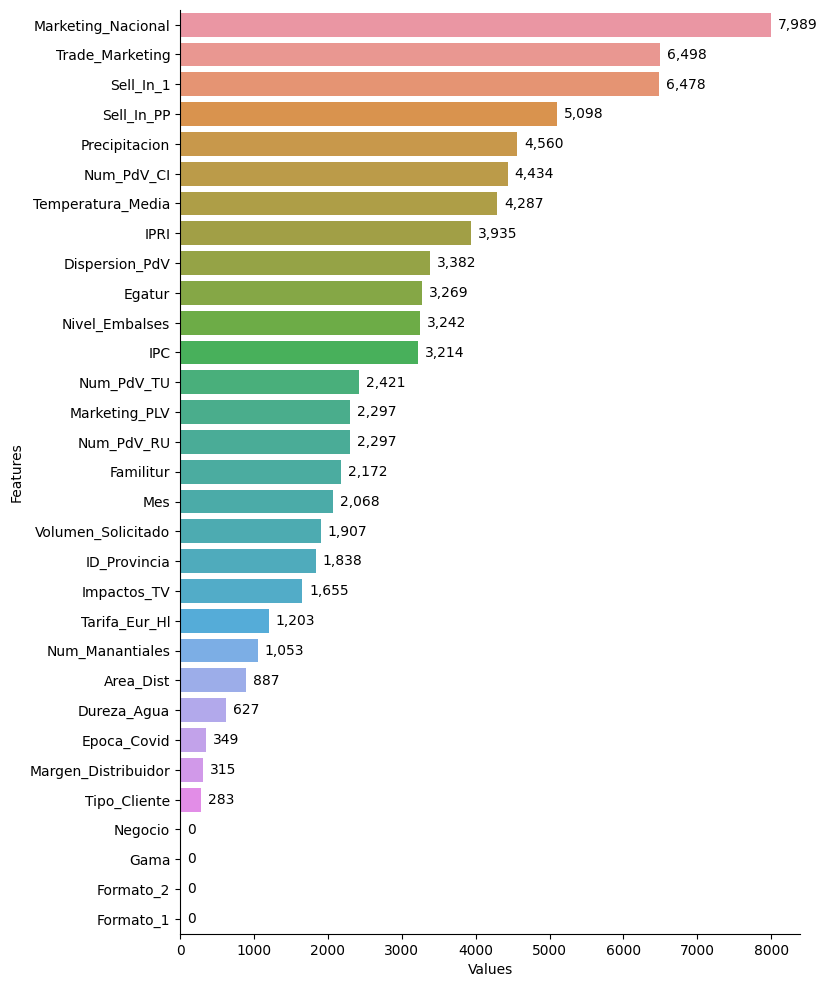

In [137]:
# Pintar Feature Importance del modelo
# ------------------------------------------------------------------------------------
plot_feature_importance(lgb_una_ret_medio_litro)

### 3.5.2. Predicciones dataset de validación

In [88]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='Barril') & (df_val.Formato_2=='Barril')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_barril_barril
# -----------------------------------------------------------------------------
df_analysis_une_barril_barril, metrics_val_une_barril_barril = execute_analysis(df_val_exp, uri_lgb_une_barril_barril)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/ec27a084bbfc4646a6256c0282730968/lightgbm-model-une-barril-barril




Métricas:
--------------------------------------------------
{
    "mae_val": 7.924,
    "score_val": 0.758
}


In [89]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='Retornable') & (df_val.Formato_2=='Tercio')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_ret_tercio
# -----------------------------------------------------------------------------
df_analysis_une_ret_tercio, metrics_val_une_ret_tercio = execute_analysis(df_val_exp, uri_lgb_une_ret_tercio)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/1d1ea31eae4f4718bfc5ee48b4f00956/lightgbm-model-une-ret-tercio




Métricas:
--------------------------------------------------
{
    "mae_val": 4.913,
    "score_val": 0.813
}


In [90]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='Retornable') & (df_val.Formato_2=='Quinto')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_ret_quinto
# -----------------------------------------------------------------------------
df_analysis_une_ret_quinto, metrics_val_une_ret_quinto = execute_analysis(df_val_exp, uri_lgb_une_ret_quinto)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/1713512f983541f9a55e5d5bf1413920/lightgbm-model-une-ret-quinto




Métricas:
--------------------------------------------------
{
    "mae_val": 3.764,
    "score_val": 0.818
}


In [91]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='No retornable') & (df_val.Formato_2=='Tercio SR')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_no_ret_terciosr
# -----------------------------------------------------------------------------
df_analysis_une_no_ret_terciosr, metrics_val_une_no_ret_terciosr = execute_analysis(df_val_exp, uri_lgb_une_no_ret_terciosr)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/b551af0eb0d744e48483fbd30f76c496/lightgbm-model-une-no-ret-terciosr




Métricas:
--------------------------------------------------
{
    "mae_val": 1.326,
    "score_val": 0.675
}


In [92]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='No retornable') & (df_val.Formato_2=='PET 1,50 L')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_no_ret_pet_1_5
# -----------------------------------------------------------------------------
df_analysis_una_no_ret_pet_1_5, metrics_val_una_no_ret_pet_1_5 = execute_analysis(df_val_exp, uri_lgb_una_no_ret_pet_1_5)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/3f9eaa1c96244ce7924c3d1f187f1fa3/lightgbm-model-una-no-ret-pet-1_5




Métricas:
--------------------------------------------------
{
    "mae_val": 11.51,
    "score_val": 0.57
}


In [93]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='No retornable') & (df_val.Formato_2=='PET 0,50 L')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_no_ret_pet_0_5
# -----------------------------------------------------------------------------
df_analysis_una_no_ret_pet_0_5, metrics_val_una_no_ret_pet_0_5 = execute_analysis(df_val_exp, uri_lgb_una_no_ret_pet_0_5)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/2b971823d9754e8bbf5994dedfeaff06/lightgbm-model-una-no-ret-pet-0_5




Métricas:
--------------------------------------------------
{
    "mae_val": 5.143,
    "score_val": 0.462
}


In [94]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='Retornable') & (df_val.Formato_2=='LITRO')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_ret_litro
# -----------------------------------------------------------------------------
df_analysis_una_ret_litro, metrics_val_una_ret_litro = execute_analysis(df_val_exp, uri_lgb_una_ret_litro)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/3947538dc2644c2baa6d8f98be398ba1/lightgbm-model-una-ret-litro




Métricas:
--------------------------------------------------
{
    "mae_val": 5.728,
    "score_val": 0.689
}


In [95]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='Retornable') & (df_val.Formato_2=='MEDIO LITRO')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_ret_medio_litro
# -----------------------------------------------------------------------------
df_analysis_una_ret_medio_litro, metrics_val_una_ret_medio_litro = execute_analysis(df_val_exp, uri_lgb_una_ret_medio_litro)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/0342d5505b144a8d966d801e9a3ca3cd/lightgbm-model-una-ret-medio-litro




Métricas:
--------------------------------------------------
{
    "mae_val": 3.917,
    "score_val": 0.685
}


In [96]:
# Meter prediccion global para el resto de categorías

# Dataset de validación:
# -----------------------------------------------------------------------------
lista_excluidos = ['Barril', 'Tercio', 'Quinto', 'Tercio SR', 'PET 1,50 L', 'PET 0,50 L', 'LITRO', 'MEDIO LITRO']
filtro = ~df_val.Formato_2.isin(lista_excluidos)
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_global
# -----------------------------------------------------------------------------
df_analysis_global_resto, metrics_val_global_resto = execute_analysis(df_val_exp, uri_lgb_global)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/e3bc49a39dab4b7284838aca19ec66b3/lightgbm-model-global




Métricas:
--------------------------------------------------
{
    "mae_val": 4.009,
    "score_val": 0.621
}


In [97]:
# Concatenar los DataFrames
df_analysis = pd.concat([
    df_analysis_une_barril_barril,
    df_analysis_une_ret_tercio,
    df_analysis_une_ret_quinto,
    df_analysis_une_no_ret_terciosr,
    df_analysis_una_no_ret_pet_1_5,
    df_analysis_una_no_ret_pet_0_5,
    df_analysis_una_ret_litro,
    df_analysis_una_ret_medio_litro,
    df_analysis_global_resto
], axis=0)

df_analysis.shape

(178, 9)

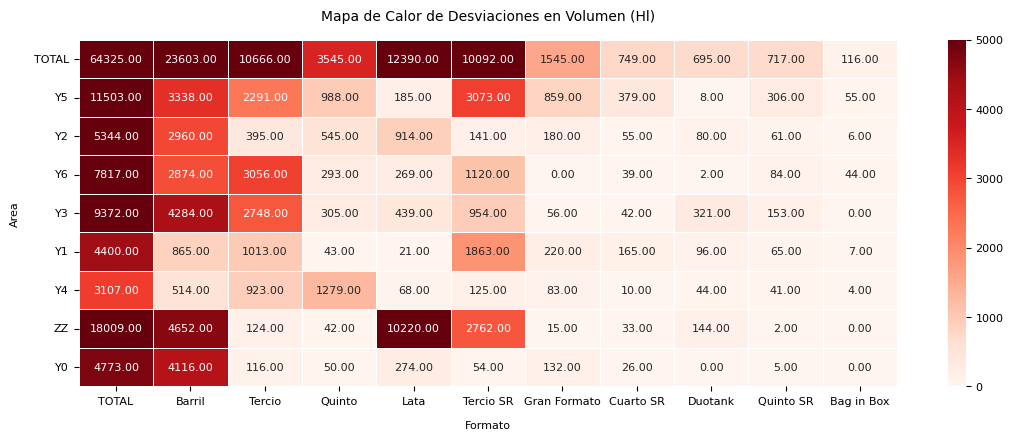

In [98]:
# Graficar mapa de calor de UNE de Volumen
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_vol(df_analysis, negocio='UNE', rango=5000)

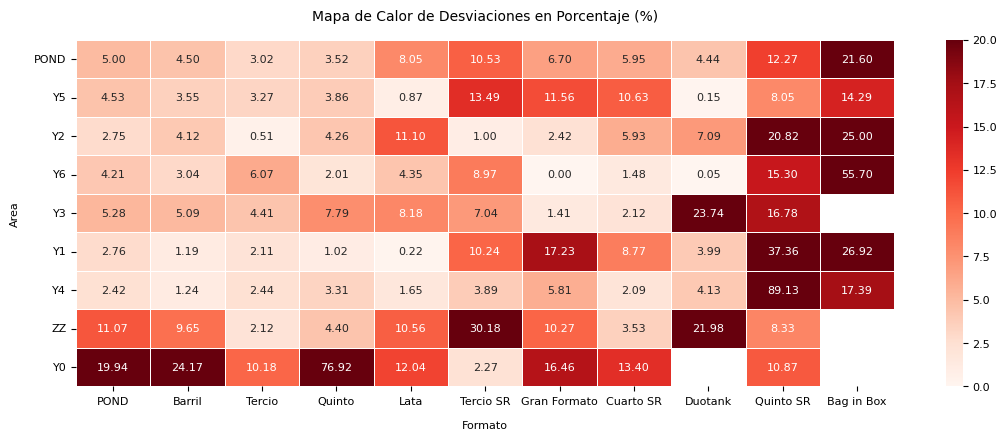

In [99]:
# Graficar mapa de calor de UNE en Porcentaje
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_pct(df_analysis, negocio='UNE', rango=20)

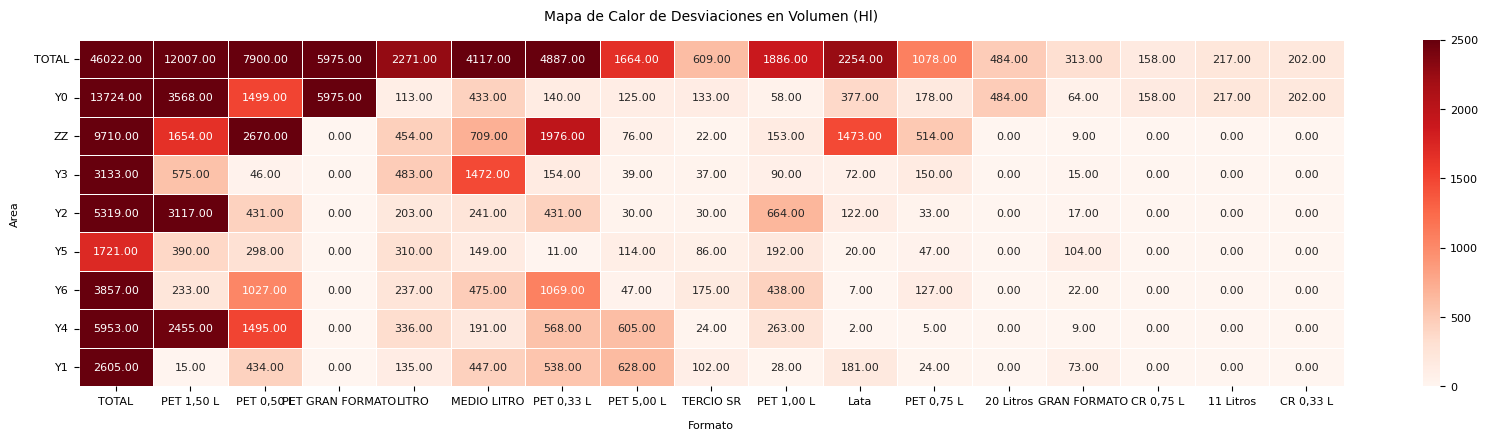

In [100]:
# Graficar mapa de calor de UNA de Volumen
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_vol(df_analysis, negocio='UNA', rango=2500)

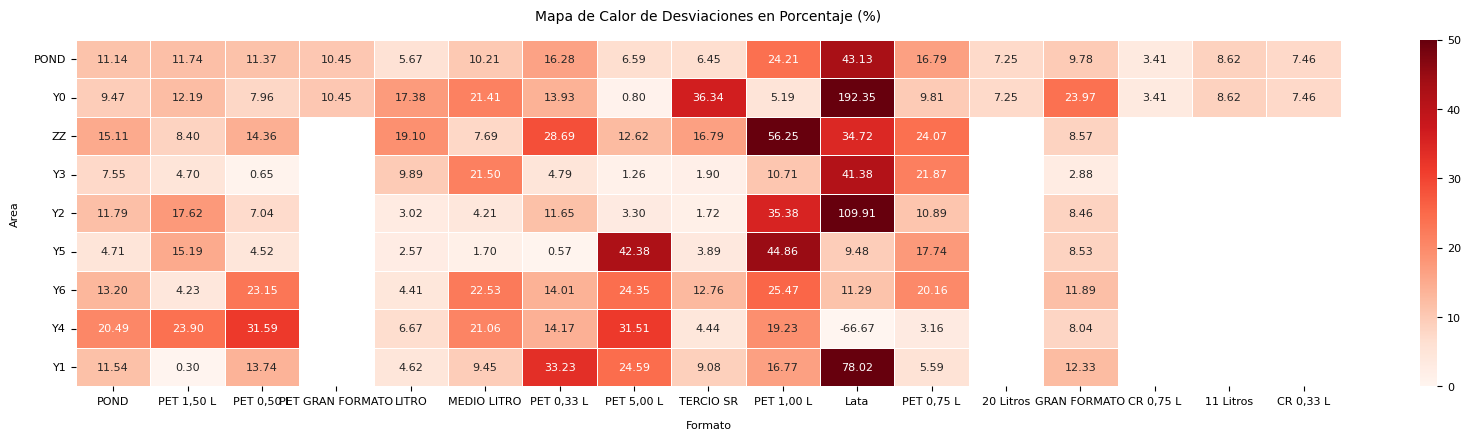

In [101]:
# Graficar mapa de calor de UNA en Porcentaje
# -----------------------------------------------------------------------------
plot_heatmap_desviaciones_pct(df_analysis, negocio='UNA', rango=50)

## 3.5. Análisis de métricas

In [102]:
# Crear un diccionario de diccionarios 3 meses de validación
dict_metrics = {
    'global': metrics_global | metrics_val_global,
    'une': metrics_une | metrics_val_une,
    'una': metrics_una | metrics_val_una,
    'une_barril': metrics_une_barril | metrics_val_une_barril,
    'une_ret': metrics_une_ret | metrics_val_une_ret,
    'une_no_ret': metrics_une_no_ret | metrics_val_une_no_ret,
    'una_ret': metrics_una_ret | metrics_val_una_ret,
    'una_no_ret': metrics_una_no_ret | metrics_val_una_no_ret,
    'une_barril_barril': metrics_une_barril_barril | metrics_val_une_barril_barril,
    'une_ret_tercio': metrics_une_ret_tercio | metrics_val_une_ret_tercio,
    'une_ret_quinto': metrics_une_ret_quinto | metrics_val_une_ret_quinto,
    'une_no_ret_tercio_sr': metrics_une_no_ret_terciosr | metrics_val_une_no_ret_terciosr,
    'una_no_ret_pet_1_5': metrics_una_no_ret_pet_1_5 | metrics_val_una_no_ret_pet_1_5,
    'una_no_ret_pet_0_5': metrics_una_no_ret_pet_0_5 | metrics_val_una_no_ret_pet_0_5,
    'una_ret_litro': metrics_una_ret_litro | metrics_val_una_ret_litro,
    'una_ret_medio_litro': metrics_una_ret_medio_litro | metrics_val_una_ret_medio_litro,
}

# Crear el DataFrame
df_metrics = pd.DataFrame.from_dict(dict_metrics, orient='index')

# Mostrar el DataFrame
df_metrics[['mae_train', 'mae_test', 'mae_val', 'score_train', 'score_test', 'score_val']]

,mae_train,mae_test,mae_val,score_train,score_test,score_val
global,1.838,3.188,4.367,0.888,0.804,0.718
une,1.391,3.000,3.691,0.920,0.828,0.769
una,2.435,3.743,6.339,0.818,0.732,0.555
une_barril,3.043,6.517,7.868,0.919,0.827,0.748
une_ret,1.514,3.286,4.551,0.940,0.868,0.817
une_no_ret,0.681,1.529,2.018,0.881,0.755,0.689
una_ret,1.686,3.489,4.868,0.882,0.740,0.686
una_no_ret,2.398,4.162,6.618,0.818,0.685,0.523
une_barril_barril,2.946,6.735,7.924,0.924,0.827,0.758
une_ret_tercio,1.188,3.722,4.913,0.953,0.868,0.813


In [318]:
# Crear un diccionario de diccionarios 3 meses de validación
dict_metrics = {
    'global': metrics_global | metrics_val_global,
    'une': metrics_une | metrics_val_une,
    'una': metrics_una | metrics_val_una,
    'une_barril': metrics_une_barril | metrics_val_une_barril,
    'une_ret': metrics_une_ret | metrics_val_une_ret,
    'une_no_ret': metrics_une_no_ret | metrics_val_une_no_ret,
    'una_ret': metrics_una_ret | metrics_val_una_ret,
    'una_no_ret': metrics_una_no_ret | metrics_val_una_no_ret,
    'une_barril_barril': metrics_une_barril_barril | metrics_val_une_barril_barril,
    'une_ret_tercio': metrics_une_ret_tercio | metrics_val_une_ret_tercio,
    'une_ret_quinto': metrics_une_ret_quinto | metrics_val_une_ret_quinto,
    'une_no_ret_tercio_sr': metrics_une_no_ret_terciosr | metrics_val_une_no_ret_terciosr,
    'una_no_ret_pet_1_5': metrics_una_no_ret_pet_1_5 | metrics_val_una_no_ret_pet_1_5,
    'una_no_ret_pet_0_5': metrics_una_no_ret_pet_0_5 | metrics_val_una_no_ret_pet_0_5,
    'una_ret_litro': metrics_una_ret_litro | metrics_val_una_ret_litro,
    'una_ret_medio_litro': metrics_una_ret_medio_litro | metrics_val_una_ret_medio_litro,
}

# Crear el DataFrame
df_metrics = pd.DataFrame.from_dict(dict_metrics, orient='index')

# Mostrar el DataFrame
df_metrics[['mae_train', 'mae_test', 'mae_val', 'score_train', 'score_test', 'score_val']]

,mae_train,mae_test,mae_val,score_train,score_test,score_val
global,1.838,3.188,4.367,0.888,0.804,0.718
une,1.391,3.000,3.691,0.920,0.828,0.769
una,2.435,3.743,6.188,0.818,0.732,0.565
une_barril,1.929,6.347,7.977,0.949,0.831,0.745
une_ret,0.907,3.269,4.597,0.964,0.869,0.815
une_no_ret,0.441,1.489,2.003,0.923,0.761,0.692
una_ret,1.300,3.519,4.779,0.909,0.738,0.692
una_no_ret,1.705,3.981,6.597,0.871,0.699,0.525
une_barril_barril,1.880,6.617,8.193,0.952,0.830,0.750
une_ret_tercio,0.696,3.664,5.132,0.972,0.870,0.805


In [146]:
# Crear un diccionario de diccionarios 2 meses de validación
dict_metrics = {
    'global': metrics_global | metrics_val_global,
    'une': metrics_une | metrics_val_une,
    'una': metrics_una | metrics_val_una,
    'une_barril': metrics_une_barril | metrics_val_une_barril,
    'une_ret': metrics_une_ret | metrics_val_une_ret,
    'une_no_ret': metrics_une_no_ret | metrics_val_une_no_ret,
    'una_ret': metrics_una_ret | metrics_val_una_ret,
    'una_no_ret': metrics_una_no_ret | metrics_val_una_no_ret,
    'une_barril_barril': metrics_une_barril_barril | metrics_val_une_barril_barril,
    'une_ret_tercio': metrics_une_ret_tercio | metrics_val_une_ret_tercio,
    'une_ret_quinto': metrics_une_ret_quinto | metrics_val_une_ret_quinto,
    'une_no_ret_tercio_sr': metrics_une_no_ret_terciosr | metrics_val_une_no_ret_terciosr,
    'una_no_ret_pet_1_5': metrics_una_no_ret_pet_1_5 | metrics_val_una_no_ret_pet_1_5,
    'una_no_ret_pet_0_5': metrics_una_no_ret_pet_0_5 | metrics_val_una_no_ret_pet_0_5,
    'una_ret_litro': metrics_una_ret_litro | metrics_val_una_ret_litro,
    'una_ret_medio_litro': metrics_una_ret_medio_litro | metrics_val_una_ret_medio_litro,
}

# Crear el DataFrame
df_metrics = pd.DataFrame.from_dict(dict_metrics, orient='index')

# Mostrar el DataFrame
df_metrics[['mae_train', 'mae_test', 'mae_val', 'score_train', 'score_test', 'score_val']]

,mae_train,mae_test,mae_val,score_train,score_test,score_val
global,1.850,3.260,4.750,0.887,0.802,0.721
une,1.385,2.934,3.996,0.920,0.833,0.776
una,1.781,3.589,6.533,0.868,0.720,0.555
une_barril,1.954,6.638,8.401,0.948,0.829,0.764
une_ret,0.919,3.439,4.575,0.963,0.867,0.833
une_no_ret,0.449,1.532,2.052,0.921,0.752,0.716
una_ret,1.303,3.413,4.717,0.909,0.744,0.696
una_no_ret,1.728,3.969,6.734,0.869,0.710,0.534
une_barril_barril,1.896,6.737,8.400,0.951,0.832,0.775
une_ret_tercio,0.702,3.461,4.882,0.972,0.877,0.832
